In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def PLOG(msg, attr='yellow'):
    print(_c(f'\n<<{"-"*(50-(len(msg)+1)//2)} {msg} {"-"*(50-len(msg)//2)}>>', attr=attr), flush=True)

/tmp/ipykernel_155508/959448426.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# command = " --dataset ShoppingAds-100K \
#             --maxlen 32 \
#             --net elias \
#             --stage 1 \
#             --loss joint \
#             --xc-lr 1e-1 \
#             --enc-lr 1e-5 \
#             --bsz 1024 \
#             --W-accum-steps 10 \
#             --no-amp-encode \
#             --cmat-seed -1 \
#             --device cuda:11 \
#             --joint-loss-gamma 0 \
#             --clf-dim 0"

command = " --dataset amazon-670k \
            --expname Stage-1-0 \
            --num-epochs 0"

## Initialize

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
from nns import exact_search
from resources import _c, printacc, read_sparse_mat, get_text, _filter, XCMetrics, get_free_gpu
from dl_base import ToD, PreTokBertDataset, XCCollator, TransformerInputLayer, FixedDataset, csr_to_pad_tensor, dedup_tensor
from nets import *
from losses import *

import json, socket, sys, os
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sp
from sklearn.preprocessing import normalize
import xclib.data.data_utils as data_utils
from xclib.utils.sparse import retain_topk
import xclib.evaluation.xc_metrics as xc_metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoModel, AutoTokenizer
transformers.set_seed(42)

import pecos
from pecos.xmc import Indexer, LabelEmbeddingFactory
from pecos.xmc.xlinear.model import XLinearModel

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [6]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--project', default='ELIAS')
parser.add_argument('--expname', default='')
parser.add_argument('--dataset', required=True)
parser.add_argument('--maxlen', type=int, default=32, help='max seq length for transformer')
parser.add_argument('--net', default='ELIAS')
parser.add_argument('--stage', type=int, default=1)
parser.add_argument('--loss', default='joint')
parser.add_argument('--loss-with-logits', action='store_true', default=False)
parser.add_argument('--joint-loss-gamma', type=float, default=0.05)
parser.add_argument('--tf', default='distilbert-base-uncased')
parser.add_argument('--tf-pooler', default='cls')

parser.add_argument('--C', type=int, default=0)
parser.add_argument('--max-leaf', type=int, default=100)
parser.add_argument('--beam', type=int, default=20)
parser.add_argument('--alpha', type=int, default=10)
parser.add_argument('--beta-gain', type=float, default=1.5)
parser.add_argument('--K', type=int, default=2000)
parser.add_argument('--kappa', type=int, default=1000)
# parser.add_argument('--beam-loss-gamma', type=float, default=0)

parser.add_argument('--warmup', type=float, default=0.1, help='warmup steps percentage')
parser.add_argument('--W-accum-steps', type=int, default=1)
parser.add_argument('--no-amp-encode', dest='amp_encode', action='store_false', help='do not use amp for encoder')
parser.add_argument('--clf-dim', type=int, default=0)
parser.add_argument('--bottleneck', type=int, default=0)
parser.add_argument('--norm-embs', action='store_true', help='Normalize encoder embeddings', default=False)
parser.add_argument('--dropout', type=float, default=0.5)
parser.add_argument('--xc-lr', type=float, default=0.01)
parser.add_argument('--dense-lr', type=float, default=-1.0)
parser.add_argument('--enc-lr', type=float, default=5e-5)
parser.add_argument('--bsz', type=int, default=128)
parser.add_argument('--num-epochs', type=int, default=25)
parser.add_argument('--eval-interval', type=int, default=3)
parser.add_argument('--use-swa', dest='use_swa', action='store_true')
parser.add_argument('--swa-step', type=int, default=1000)
parser.add_argument('--swa-start', type=int, default=8)

parser.add_argument('--embs-dir', default='')
parser.add_argument('--save', action='store_true', help='save model and score mat', default=False)
parser.add_argument('--resume-path', help='continue training from previous checkpoint', default='')
parser.add_argument('--cmat-file', help='saved cluster matrix npz file', default='')
parser.add_argument('--cmat-seed', help='initial cluster matrix seed', default=-1, type=int)
parser.add_argument('--A-init-file', help='saved candidates npz file', default='')
parser.add_argument('--save-embs', action='store_true', default=False)
parser.add_argument('--gen-A-init', action='store_true', help='generate an initialization for A with final model', default=False)
parser.add_argument('--ranker', action='store_true', default=False)
parser.add_argument('--ranker-alpha', type=float, default=0.5)
parser.add_argument('--ranker-topk', type=int, default=100)
parser.add_argument('--score-calibrate', action='store_true', default=False)

parser.add_argument('--device', default='cuda:0')
parser.set_defaults(amp_encode=True)
parser.set_defaults(use_swa=False)

args = parser.parse_args(command.split())
if args.expname != '' and args.num_epochs == 0:
    args.__dict__ = json.load(open(f'Results/{args.project}/{args.dataset}/{args.expname}/args.json'))
    parser.set_defaults(**args.__dict__)
    args = parser.parse_args(command.split())
    
args.use_grad_scaler = (args.amp_encode)
args.hostname = socket.gethostname()

cmat_seed_suffix = '' if args.cmat_seed < 0 == '' else f'-{args.cmat_seed}'
args.netname = args.net if args.net == 'fcnet' else f'{args.net}-{args.stage}-leaf{args.max_leaf}-beam{args.beam}{cmat_seed_suffix}'
args.expname = nb_name.split('.')[0]

args.dense_lr = args.xc_lr if args.dense_lr < 0 else args.dense_lr
args.tf = None if args.tf.lower() == 'none' else args.tf
args.embs_dim = 768

args.DATA_DIR = DATA_DIR = f'Datasets/{args.dataset}'
args.OUT_DIR = OUT_DIR = f'Results/{args.project}/{args.dataset}/{args.expname}'
os.makedirs(OUT_DIR, exist_ok=True)
print(f'expname: {_c(args.expname, attr="blue")}, dataset: {_c(args.dataset, attr="blue")}')

args.cmat_file = f'{DATA_DIR}/cmat-{args.C}x{args.max_leaf}{cmat_seed_suffix}.npz' if args.cmat_file == '' else args.cmat_file

if not os.path.exists(args.A_init_file):
    args.A_init_file = f'{os.path.dirname(args.resume_path)}/A_init.npz'

expname: ELIAS, dataset: amazon-670k


## Load data

In [14]:
Y = [x.strip() for x in open(f'{DATA_DIR}/raw/Y.txt').readlines()]
# trnX = [x.strip() for x in open(f'{DATA_DIR}/raw/trn_X.txt').readlines()]
# tstX = [x.strip() for x in open(f'{DATA_DIR}/raw/tst_X.txt').readlines()]

trn_X_Y = sp.load_npz(f'{DATA_DIR}/Y.trn.npz')
tst_X_Y = sp.load_npz(f'{DATA_DIR}/Y.tst.npz')
trn_Y_X = trn_X_Y.T.tocsr()

args.numy = trn_X_Y.shape[1]
args.C = int(2**np.ceil(np.log2(args.numy/args.max_leaf)))
tst_filter_mat = None
if os.path.exists('%s/tst_filter_labels.txt'%(DATA_DIR)):
    temp = np.fromfile('%s/tst_filter_labels.txt'%(DATA_DIR), sep=' ').astype(int)
    temp = temp.reshape(-1, 2).T
    tst_filter_mat = sp.coo_matrix((np.ones(temp.shape[1]), (temp[0], temp[1])), tst_X_Y.shape).tocsr()
    
if "amazon" in args.dataset.lower(): A = 0.6; B = 2.6
elif "wiki" in args.dataset.lower() and "wikiseealso" not in args.dataset.lower(): A = 0.5; B = 0.4
else : A = 0.55; B = 1.5
inv_prop = xc_metrics.compute_inv_propesity(trn_X_Y, A, B)

In [10]:
# trn_nnz = trn_X_Y.getnnz(1)
# trn_sample = np.argsort(trn_nnz)[-1000000:]

trn_sample = None

In [11]:
if args.tf is not None:
    args.token_type = 'bert-base-uncased'
    if 'roberta' in args.tf: args.token_type = 'roberta-base'
    trn_dataset = PreTokBertDataset(f'{DATA_DIR}/{args.token_type}-{args.maxlen}', trn_X_Y, args.maxlen, doc_type='trn', sample=trn_sample)
    tst_dataset = PreTokBertDataset(f'{DATA_DIR}/{args.token_type}-{args.maxlen}', tst_X_Y, args.maxlen, doc_type='tst')
else:
    if args.embs_dir is None:
        args.embs_dir = f'Datasets/{args.dataset}/embs/XRL-batch-bce'
    trn_embs = np.load(f'{args.embs_dir}/trn_embs.npy')
    tst_embs = np.load(f'{args.embs_dir}/tst_embs.npy')
    trn_dataset = FixedDataset(trn_embs, trn_X_Y)
    tst_dataset = FixedDataset(tst_embs, tst_X_Y)

# trn_dataset.labels = trn_Y_X
trn_loader = torch.utils.data.DataLoader(
    trn_dataset,
    batch_size=args.bsz,
    num_workers=4,
    collate_fn=XCCollator(trn_X_Y.shape[1], trn_dataset),
    shuffle=True,
    pin_memory=True)

tst_loader = torch.utils.data.DataLoader(
    tst_dataset,
    batch_size=args.bsz*2,
    num_workers=4,
    collate_fn=XCCollator(trn_X_Y.shape[1], tst_dataset),
    shuffle=False,
    pin_memory=True)

In [12]:
A1 = sp.load_npz(f'Results/ELIAS/amazon-670k/Stage-1-0/A_init.npz')
A2 = sp.load_npz(f'Results/ELIAS/amazon-670k/Stage-1-0/A_init.orig.npz')

In [20]:
temp = _filter(A1, A2)

/home/nilesh/miniconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Cluster utils

In [9]:
args.cmat_file = f'{DATA_DIR}/cmat-{args.nr_splits}x{args.max_leaf}.npz'
cmat = sp.load_npz(args.cmat_file)

cmat.resize(args.nr_splits, args.numy)
c_tst_X_Y = tst_X_Y.dot(cmat.T)
c_tst_X_Y.data[:] = 1.0

# cmat.resize(args.nr_splits+1, args.numy+1)

AttributeError: 'Namespace' object has no attribute 'nr_splits'

In [66]:
qbst_trn_X_Xf = sp.load_npz(f'{DATA_DIR}/X_qbst.trn.npz')

In [67]:
trn_X_Xf = sp.load_npz(f'{DATA_DIR}/X.trn.npz')

In [72]:
normalize(qbst_trn_X_Xf, axis=1, copy=False)

<286541251x33121061 sparse matrix of type '<class 'numpy.float32'>'
	with 5724552126 stored elements in Compressed Sparse Row format>

In [77]:
new_cmats = {}
# %time label_feat = LabelEmbeddingFactory.create(trn_X_Y.astype(np.float32), qbst_trn_X_Xf.astype(np.float32), method="pifa")
# for seed in [0]:
#     %time cluster_chain = Indexer.gen(label_feat, indexer_type="hierarchicalkmeans", nr_splits=args.C, max_leaf_size=args.max_leaf, seed=seed)
new_cmats[seed] = cluster_chain.chain[-1].T

In [78]:
for seed, mat in new_cmats.items():
    sp.save_npz(f'{DATA_DIR}/qbst-cmat-{args.C}x{args.max_leaf}-{seed}.npz', mat)

In [40]:
if False:
    trn_X_Xf = normalize(read_sparse_mat(f'{DATA_DIR}/trn_X_Xf.txt', use_xclib=False), copy=False)
    trn_embs = normalize(np.load(f'{DATA_DIR}/embs/XRL-batch-bce/trn_embs.npy'), copy=False)
    trn_X_Xf = sp.hstack((trn_X_Xf, trn_embs)).tocsr()

    new_cmats = {}
    label_feat = LabelEmbeddingFactory.create(trn_X_Y, trn_X_Xf.astype(np.float32), method="pifa")
    for seed in [0, 1, 2]:
        %time cluster_chain = Indexer.gen(label_feat, indexer_type="hierarchicalkmeans", nr_splits=args.nr_splits, max_leaf_size=args.max_leaf, seed=seed)
        new_cmats[seed] = cluster_chain.chain[-1].T

    new_cmat = sp.vstack(new_cmats.values())
    sp.save_npz(f'{OUT_DIR}/new_cmat.npz', new_cmat)

    args.nr_splits = new_cmat.shape[0]
    for seed, mat in new_cmats.items():
        sp.save_npz(f'{DATA_DIR}/cmat-{args.nr_splits}x{args.max_leaf}-{seed}.npz', mat)

## Architecture and Loss definitions

In [22]:
class ELIAS(Net):
    def __init__(self, args, rand_init=True):
        super(ELIAS, self).__init__(args)
    
        self.stage = args.stage
        self.beam = args.beam
        self.max_trn_cluster = self.beam+10
        self.numy = args.numy
        self.loss_with_logits = args.loss_with_logits
        self.tau = 1
        self.alpha = args.alpha
        self.beta = int(args.max_leaf*args.beta_gain)
        self.K = args.K
        self.C = args.C
        self.max_leaf = args.max_leaf
        self.embs_dim = args.embs_dim
        self.clf_dim = args.clf_dim if args.clf_dim > 0 else args.embs_dim
        
        self.w1 = nn.Linear(self.embs_dim, args.C+1)
        self.transform = nn.Linear(self.embs_dim, self.clf_dim) if (self.embs_dim != self.clf_dim) else nn.Identity()
        self.w_leaf = SparseLinear(args.numy+1, self.clf_dim)

        self.bow_fts = normalize(sp.load_npz(f'{args.DATA_DIR}/X.trn.npz'), copy=False).astype(np.float32)
        self.OUT_DIR = args.OUT_DIR
        self.cmat_seed = args.cmat_seed
        if os.path.exists(args.A_init_file):
            A_init = sp.load_npz(args.A_init_file)
            temp = csr_to_pad_tensor(A_init, args.numy)
            self.A_nz_inds = temp['inds'].to(args.device)
#             self.A_nz_vals = nn.Parameter(torch.rand(*self.A_nz_inds.shape)) if rand_init else nn.Parameter(res['vals'].float())
            init_vals = temp['vals'].float() / torch.clamp(temp['vals'].float().max(dim=1).values.reshape(-1, 1), min=1e-8)
            init_vals += 0.2*torch.rand(*self.A_nz_inds.shape)
            self.A_nz_vals = nn.Parameter(init_vals)
        
        self.no_swa = lambda n: (n == 'A_nz_vals')
        
    def retain_topk(self, K, clean=False):
        with torch.no_grad():
            self.A_norm_nz_vals = torch.clamp(self.beta*F.softmax(self.A_nz_vals/self.tau, dim=-1), min=0, max=1)
            self.A_nz_vals.data, sorted_inds = self.A_nz_vals.topk(K)
            self.A_nz_inds = self.A_nz_inds.gather(1, sorted_inds)
            self.A_norm_nz_vals = self.A_norm_nz_vals.gather(1, sorted_inds)
            
            if clean:
                self.A_nz_vals.data[:] = 1
                self.A_norm_nz_vals[:] = 1
                
    def update(self, epoch=-1, trn_dataset=None, **kwargs):    
        if self.stage == 1:
            if self.cmat_seed > -1 and (epoch == 0 or epoch == 5):
                print(f'Updating clusters at epoch {epoch}...')
                trn_embs = normalize(self.get_embs(trn_dataset), copy=False).astype(np.float32)
                cluster_embs = sp.hstack((self.bow_fts, trn_embs)).tocsr()
                    
                label_feat = LabelEmbeddingFactory.create(trn_dataset.labels, cluster_embs, method="pifa")
                cmat = Indexer.gen(label_feat, 
                                   indexer_type="hierarchicalkmeans", 
                                   nr_splits=self.C, 
                                   max_leaf_size=self.max_leaf, 
                                   seed=self.cmat_seed).chain[-1].T
                cmat.resize(self.C+1, self.numy+1)
                sp.save_npz(f'{self.OUT_DIR}/cmat.npz', cmat)
                temp = csr_to_pad_tensor(cmat, self.numy)
                self.A_nz_inds = temp['inds'].to(self.get_device())
                self.A_nz_vals = temp['vals'].to(self.get_device())
                self.parent = torch.tensor(cmat.argmax(0)).ravel().to(self.get_device())
                self.parent[self.numy] = self.C

        with torch.no_grad():
            self.A_norm_nz_vals = torch.clamp(self.beta*F.softmax(self.A_nz_vals/self.tau, dim=-1), min=0, max=1).to(self.get_device())
            self.parent = torch.zeros((self.numy+1, ), dtype=torch.long, device=self.get_device())
            parent_val = torch.zeros((self.numy+1, ), device=self.get_device())
            for c in range(self.A_norm_nz_vals.shape[0]):
                cy = self.A_nz_inds[c]
                self.parent[cy] = torch.where(parent_val[cy] < self.A_norm_nz_vals[c], torch.full(cy.shape, c, device=self.get_device()), self.parent[cy])
                parent_val[cy] = torch.max(parent_val[cy], self.A_norm_nz_vals[c])

    def forward(self, b, K=0):
        b = self.ToD(b)
        embs = self.encode(b)
        bsz = embs.shape[0]
        K = max(self.beam, K)
        
        out1 = torch.clamp(self.alpha*F.softmax(self.w1(embs), dim=1), min=0, max=1)[:, :-1]
        out1_topk_vals, out1_topk_inds = torch.topk(out1, K, dim=1)
    
        if self.training:
            if self.A_nz_vals.requires_grad:
                self.A_norm_nz_vals = torch.clamp(self.beta*F.softmax(self.A_nz_vals/self.tau, dim=-1), min=0, max=1)
            if self.w1.weight.requires_grad:
                # add parent clusters in shortlisted clusters
                out1_pos_inds = self.parent[b['y']['inds']]
                out1_topk_inds = torch.hstack((out1_topk_inds, out1_pos_inds))
                out1_topk_vals = torch.hstack((out1_topk_vals, b['y']['vals']))

                out1_topk_inds, rearranged_inds = dedup_tensor(out1_topk_inds, replace_val=self.C, return_indices=True)
                out1_topk_vals = out1_topk_vals.gather(1, rearranged_inds)
                if self.max_trn_cluster > 0 and self.max_trn_cluster < out1_topk_vals.shape[1]:
                    sampled_inds = torch.multinomial(out1_topk_vals, self.max_trn_cluster)
                    out1_topk_inds = out1_topk_inds.gather(1, sampled_inds)
                pad_mask = (out1_topk_inds == self.C)
                out1_topk_inds[pad_mask] = torch.randint(0, self.C, (pad_mask.sum(), ), device=pad_mask.device)
        out1_topk_vals = out1.gather(1, out1_topk_inds)
        
        topk_C_vals = self.A_norm_nz_vals[out1_topk_inds.flatten()]
        topk_C_vals *= out1_topk_vals.reshape(-1, 1)
        topk_C_vals = topk_C_vals.reshape(bsz, -1)
        
        topk_C_inds = self.A_nz_inds[out1_topk_inds.flatten()].reshape(bsz, -1)
        topk_C_vals, sort_inds = torch.sort(topk_C_vals, descending=True)
        topk_C_inds = topk_C_inds.gather(1, sort_inds)
        
        topk_C_inds, rearranged_inds = dedup_tensor(topk_C_inds, self.numy, return_indices=True)
        topk_C_vals = topk_C_vals.gather(1, rearranged_inds)
        topk_C_vals[topk_C_inds == self.numy] = 0 # handle pad index
        
        shorty_vals, sorted_inds = topk_C_vals.topk(min(self.K, topk_C_vals.shape[-1]))
        shorty_inds = topk_C_inds.gather(1, sorted_inds)
                
        out2 = self.w_leaf(self.transform(embs), shorty_inds)
        out2 = out2 if self.loss_with_logits else torch.sigmoid(out2)
        out = (out2 + shorty_vals) if self.loss_with_logits else (out2 * shorty_vals)

        return (out, shorty_inds, topk_C_vals, topk_C_inds) if self.training else (out, shorty_inds)

In [23]:
class JointLoss(nn.Module):
    def __init__(self, args, reduction='mean'):
        super(JointLoss, self).__init__()
        self.numy = args.numy
        self.gamma = args.joint_loss_gamma
        if args.loss_with_logits:
            self.criterion = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        else:
            self.criterion = torch.nn.BCELoss(reduction=reduction)

    def forward(self, model, b):
        out, shorty, topk_C_vals, topk_C_inds = model(b)
        
        yfull = torch.zeros((out.shape[0], self.numy+1), device=out.device).scatter_(1, b['y']['inds'], 1)
        yfull[:, -1] = 0.0
        
        targets  = torch.gather(yfull, 1, shorty)
        loss_precision = self.criterion(out, targets)
        
        targets = yfull.gather(1, topk_C_inds)
        targets, target_inds = targets.topk(targets.sum(dim=-1).max().long())
        topk_C_vals = topk_C_vals.gather(1, target_inds)
        topk_C_vals[targets < 1e-5] = 0
        loss_recall = self.criterion(topk_C_vals, targets)
        
        loss = loss_precision + self.gamma*loss_recall
        
        del b, out, yfull, targets
        return loss

In [24]:
NETS['elias'] = ELIAS
LOSSES['joint'] = JointLoss

## Setup

In [25]:
# args.A_init_file = f'{OUT_DIR}/candidates.npz'
# args.A_init_file = f'Results/ELIAS/ShoppingAds-100K/Stage-1-0/cmat.npz'
# args.A_init_file = f'{DATA_DIR}/cmat-{args.C}x{args.max_leaf}-0.npz'
# args.A_init_file = f'Results/ELIAS/ShoppingAds-10M-v2/Stage-1-0/A_init.npz'

In [302]:
net = NETS[args.net](args)
criterion = LOSSES[args.loss](args)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [303]:
net

ELIAS(
  (encoder): TransformerInputLayer(
    (transformer): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
    

In [304]:
# net.load_state_dict(torch.load(f'Results/ELIAS/amazon-670k/Stage-1-0/model.pt', map_location='cpu'), strict=False)

In [305]:
net.to(args.device);
net.update()

In [306]:
emb_mu = np.zeros((args.numy, args.embs_dim))
bow_fts = normalize(sp.load_npz(f'{DATA_DIR}/X.trn.npz'), copy=False)
bow_mu = trn_X_Y.T.tocsr().dot(bow_fts)
trn_embs = np.zeros((trn_X_Y.shape[0], args.embs_dim))

In [307]:
net.eval()
with torch.no_grad():
    for b in tqdm(trn_loader, desc='Computing embs mu'):
        b = net.ToD(b)
        b_ids = b['ids']
        embs = net.encode(b).detach()
        all_b_ids = b_ids.detach().cpu().numpy()
        all_embs = embs.detach().cpu().numpy()
        trn_embs[all_b_ids] = all_embs
        
        batch_X_Y = trn_X_Y[all_b_ids]
        all_batch_Y = np.unique(batch_X_Y.indices)
        batch_X_Y = batch_X_Y[:, all_batch_Y]
        batch_Y_mu = batch_X_Y.T.tocsr().dot(normalize(all_embs, copy=False))
        emb_mu[all_batch_Y] += batch_Y_mu

Computing embs mu: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [03:21<00:00,  4.74it/s]


In [308]:
combined_mu = normalize(sp.hstack([bow_mu, emb_mu]), copy=False).astype(np.float32)
cmat = Indexer.gen(combined_mu, 
                   indexer_type="hierarchicalkmeans", 
                   nr_splits=args.C, 
                   max_leaf_size=args.max_leaf, 
                   seed=args.cmat_seed).chain[-1].T
# sp.save_npz(f'{args.OUT_DIR}/cmat.npz')

In [309]:
cmat.indices

array([   760,   3764,   4781, ..., 652718, 655277, 662163], dtype=int32)

In [310]:
combined_mu

<670091x136677 sparse matrix of type '<class 'numpy.float32'>'
	with 659240464 stored elements in Compressed Sparse Row format>

In [311]:
label_feat

<670091x136677 sparse matrix of type '<class 'numpy.float32'>'
	with 659240467 stored elements in Compressed Sparse Row format>

abs(cmat.indices - temp_cmat.indices).sum()

In [295]:
temp_cmat = sp.load_npz(f'Results/ELIAS/amazon-670k/Stage-1-0/cmat.temp.npz')

In [296]:
temp_cmat.indices

array([   760,   3764,   4781, ..., 652718, 655277, 662163], dtype=int32)

In [293]:
orig_cmat = sp.load_npz(f'Results/ELIAS/amazon-670k/Stage-1-0/cmat.npz')

In [294]:
orig_cmat.indices

array([254247, 257041, 257177, ..., 613973, 633280, 648644], dtype=int32)

In [299]:
trn_embs = normalize(net.get_embs(trn_dataset), copy=False).astype(np.float32)
cluster_embs = sp.hstack((net.bow_fts, trn_embs)).tocsr()

label_feat = LabelEmbeddingFactory.create(trn_dataset.labels, cluster_embs, method="pifa")
net_cmat = Indexer.gen(label_feat, 
                   indexer_type="hierarchicalkmeans", 
                   nr_splits=net.C, 
                   max_leaf_size=net.max_leaf, 
                   seed=net.cmat_seed).chain[-1].T

Encoding: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1916/1916 [02:52<00:00, 11.08it/s]


In [336]:
temp_embs = sp.hstack([bow_fts, normalize(trn_embs)]).tocsr().astype(np.float32)

In [337]:
temp_label_feat = LabelEmbeddingFactory.create(trn_X_Y, temp_embs, method="pifa")

In [ ]:
temp_l

In [301]:
label_feat

<670091x136677 sparse matrix of type '<class 'numpy.float32'>'
	with 659240467 stored elements in Compressed Sparse Row format>

In [14]:
# MUFIN_DIR = '/mnt/disks/disk2/anshumitts/XC/results/ShoppingAds-10M-v2/MufinTextXC/v_default_run_d=128/module3'
# encoder_state_dict = torch.load(f'{MUFIN_DIR}/encoder.pkl', map_location='cpu')
# encoder_state_dict = {f'encoder.transformer.{".".join(k.split(".")[2:])}': v for k, v in encoder_state_dict.items()}

# net.load_state_dict(encoder_state_dict, strict=False)

In [15]:
if args.resume_path != '':
    state_dict = torch.load(f'{LOAD_DIR}/model.pt', map_location='cpu')
    new_state_dict = {k: v for k, v in state_dict.items() if 'C' not in k and 'w_leaf' not in k}
    print(net.load_state_dict(new_state_dict, strict=False))

In [16]:
# args.load_path=''
# args.load_path = 'Results/ELIAS/ShoppingAds-10M-v2/Stage-2-0-no-swa/model.pt'
args.load_path='Results/ELIAS/ShoppingAds-10M-v2/Stage-1-0-qbst/model.pt'
# args.load_path='Results/ELIAS/ShoppingAds-100K/Stage-1-0/model.pt'
# args.load_path = f'Resu'

if args.load_path != '':
    print(net.load_state_dict(torch.load(args.load_path, map_location='cpu'), strict=True))

<All keys matched successfully>


In [17]:
args.clf_dim

64

In [18]:
net.to(args.device)
net.update()

In [23]:
net.beam = 20
net.K = 2000
net.beam, net.K

(20, 2000)

In [20]:
score_mat = net.predict(tst_loader, K=700);

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [02:06<00:00,  7.38it/s]


In [21]:
from resources import recall

In [22]:
recall(score_mat, tst_X_Y, [10,20,50,100,200,300,500,700])

{'R@10': 31.645324469786974,
 'R@20': 42.655996452956494,
 'R@50': 57.939536680568246,
 'R@100': 68.4861022375928,
 'R@200': 77.31670919478695,
 'R@300': 81.47963980877768,
 'R@500': 85.56164244656284,
 'R@700': 87.59075225227345}

In [313]:
np.linalg.norm(combined_mu[0].data)

1.0

In [330]:
abs(combined_mu[1].data[-768:] - label_feat[1].data[-768:]).sum()

0.6560148

In [340]:
abs(temp_label_feat[5].data - label_feat[5].data).sum()

6.2487925e-07

In [347]:
A_bin = sp.load_npz(f'Results/ELIAS/amazon-670k/Stage-1-0-test/A_init.npz')

In [341]:
A = sp.load_npz(f'Results/ELIAS/amazon-670k/Stage-1-0-test/A_init.npz')

In [362]:
temp = sp.load_npz(f'Results/ELIAS/amazon-670k/Stage-1-0-test/A_init.npz')

In [361]:
sp.save_npz(f'Results/ELIAS/amazon-670k/Stage-1-0-test/A_init.npz', A)

In [348]:
A.getnnz(0).max(), A_bin.getnnz(0).max()

(645, 571)

In [350]:
np.where(A_bin.getnnz(0) == 0)[0].shape


(52680,)

In [355]:
import matplotlib.pyplot as plt

In [356]:
plt.style.use('default')

/home/nilesh/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

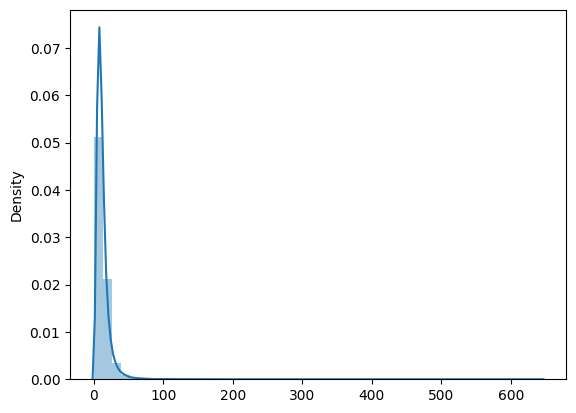

In [358]:
sns.distplot(A.getnnz(0))

/home/nilesh/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

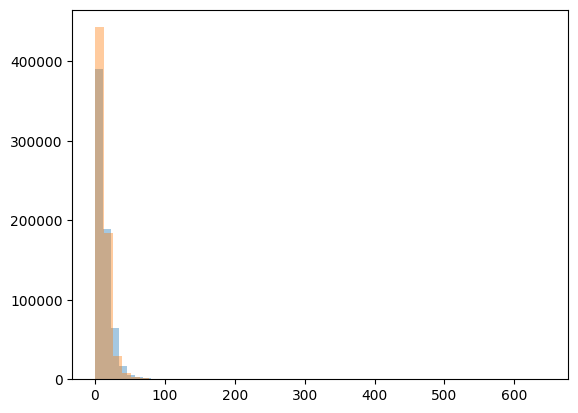

In [360]:
import seaborn as sns
sns.distplot(A_bin.getnnz(0), kde=False)
sns.distplot(A.getnnz(0), kde=False)

In [ ]:
nnz = np.where()

In [334]:
normalize(combined_mu[1].data[-768:].reshape(1, -1))

array([[-3.68854925e-02, -1.82484034e-02, -1.05221644e-02,
         1.50246490e-02, -2.89593600e-02, -4.32539685e-03,
        -9.54634696e-03, -1.55779286e-04, -2.20006239e-03,
        -2.49040257e-02, -6.59288978e-03,  9.89418197e-03,
        -4.18368615e-02,  6.36877865e-02,  3.08492668e-02,
         4.41756584e-02, -1.66690610e-02,  9.70246922e-03,
        -3.18772462e-03,  1.48165217e-02, -2.02644933e-02,
         8.35457700e-04,  2.97498256e-02,  4.67501506e-02,
        -1.36745267e-03, -5.57110365e-03, -2.22789589e-02,
        -1.03101293e-02,  7.64232548e-03,  1.89241730e-02,
        -2.77570151e-02,  1.63872782e-02,  4.67612932e-04,
        -3.79658788e-02,  2.06490792e-02, -2.74814870e-02,
         1.27543984e-02, -2.63458975e-02, -6.06203079e-03,
         9.61263571e-03, -3.60228075e-03,  6.37446623e-03,
        -2.77214404e-03, -1.92488227e-02, -1.67055391e-02,
        -7.54263438e-03, -2.79034734e-01, -2.62135305e-02,
        -4.52072825e-03,  2.73430888e-02, -6.13908865e-0

In [335]:
normalize(label_feat[1].data[-768:].reshape(1, -1))

array([[-3.65869477e-02, -1.81858353e-02, -8.12750030e-03,
         1.40299061e-02, -2.61557084e-02, -6.70622755e-03,
        -1.05847288e-02,  1.31195784e-03, -2.21949350e-03,
        -2.49404870e-02, -5.65765332e-03,  1.02618281e-02,
        -4.05083783e-02,  6.21510968e-02,  3.03413272e-02,
         4.32767645e-02, -1.74565967e-02,  9.90287587e-03,
        -1.95089984e-03,  1.56149808e-02, -1.95899643e-02,
         1.67818071e-04,  2.93865986e-02,  4.61756177e-02,
         2.36977459e-04, -4.58773924e-03, -2.15628296e-02,
        -1.16044357e-02,  6.30757120e-03,  2.09421273e-02,
        -2.67143473e-02,  1.65692493e-02,  7.73742737e-04,
        -3.69636491e-02,  1.99988354e-02, -2.67856661e-02,
         1.28347622e-02, -2.57918499e-02, -3.54756345e-03,
         9.60130896e-03, -4.35701152e-03,  6.52065314e-03,
        -1.92264828e-03, -2.07739640e-02, -1.61171816e-02,
        -7.86380656e-03, -2.81325668e-01, -2.56618187e-02,
        -3.83539940e-03,  2.24639382e-02,  1.02220976e-0

In [312]:
np.linalg.norm(label_feat[0].data)

1.0

In [28]:
XCMetrics(score_mat, tst_X_Y, inv_prop)

P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
7.15	5.28	4.35	7.15	12.07	14.46	7.23	15.33	20.9	31.0	41.88	67.66

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
7.15 5.28 4.35 7.15 12.07 14.46 7.23 15.33 20.9 31.0 41.88 67.66



P@1   P@3   P@5  nDCG@1  nDCG@3  nDCG@5  PSP@1  PSP@3  PSP@5  R@10  \
Method  7.15  5.28  4.35    7.15   12.07   14.46   7.23  15.33   20.9  31.0   

         R@20  R@100  MRR@10  
Method  41.88  67.66   13.45

In [33]:
def _no_decay(n,p):
    if n.startswith('encoder'):
        return any([x in n.lower() for x in ['bias', 'layernorm', 'layer_norm']])
    return True

def _is_enc_param(n,p):
    return n.startswith('encoder')

def _is_xc_param(n,p):
    return any((x == args.numy or x == (args.numy+1)) for x in p.shape) or n == 'A_nz_vals'

def _is_dense_param(n,p):
    return (not _is_enc_param(n,p)) and (not _is_xc_param(n,p))

optim_wrap = {
    'enc': {'class': torch.optim.AdamW, 'params': [], 'f': _is_enc_param, 'accum_steps': 1, 'args': {'lr': args.enc_lr}},
    'xc' : {'class': torch.optim.AdamW, 'params': [], 'f': _is_xc_param, 'accum_steps': args.W_accum_steps, 'args': {'lr': args.xc_lr}},
    'dense': {'class': torch.optim.AdamW, 'params': [], 'f': _is_dense_param, 'accum_steps': args.W_accum_steps, 'args': {'lr': args.dense_lr}}
    }

for n,p in net.named_parameters():
    for k in optim_wrap.keys():
        if p.requires_grad and optim_wrap[k]['f'](n,p):
            optim_wrap[k]['params'].append((n, p))

optims = {}
for k, v in optim_wrap.items():
    grouped_params = [{'params': [p for n,p in v['params'] if _no_decay(n,p)], 'weight_decay': 0}, 
                      {'params': [p for n,p in v['params'] if not _no_decay(n,p)], 'weight_decay': 0.01}]
    if len(v['params']) > 0: optims[k] = v['class'](grouped_params, **v['args'])

for k in optim_wrap.keys():
    print(_c(f'{k} parameters ({optim_wrap[k]["args"]}, accum: {optim_wrap[k]["accum_steps"]}): ', attr='bold blue'), [p[0] for p in optim_wrap[k]['params']])

enc parameters ({'lr': 1e-05}, accum: 1):  ['encoder.transformer.embeddings.word_embeddings.weight', 'encoder.transformer.embeddings.position_embeddings.weight', 'encoder.transformer.embeddings.LayerNorm.weight', 'encoder.transformer.embeddings.LayerNorm.bias', 'encoder.transformer.transformer.layer.0.attention.q_lin.weight', 'encoder.transformer.transformer.layer.0.attention.q_lin.bias', 'encoder.transformer.transformer.layer.0.attention.k_lin.weight', 'encoder.transformer.transformer.layer.0.attention.k_lin.bias', 'encoder.transformer.transformer.layer.0.attention.v_lin.weight', 'encoder.transformer.transformer.layer.0.attention.v_lin.bias', 'encoder.transformer.transformer.layer.0.attention.out_lin.weight', 'encoder.transformer.transformer.layer.0.attention.out_lin.bias', 'encoder.transformer.transformer.layer.0.sa_layer_norm.weight', 'encoder.transformer.transformer.layer.0.sa_layer_norm.bias', 'encoder.transformer.transformer.layer.0.ffn.lin1.weight', 'encoder.transformer.transfor

In [34]:
total_steps = {k: len(trn_loader)*args.num_epochs/optim_wrap[k]['accum_steps'] for k in optims.keys()}
schedulers = {k: transformers.get_linear_schedule_with_warmup(optim, num_warmup_steps=int(args.warmup*total_steps[k]), num_training_steps=total_steps[k]) for k, optim in optims.items()}

In [35]:
with open(f'{OUT_DIR}/args.json', 'w') as f:
    json.dump(args.__dict__, f, indent=2)

In [36]:
args

Namespace(A_init_file='Results/ELIAS/ShoppingAds-100K/Stage-1-0/cmat.npz', C=1024, DATA_DIR='Datasets/ShoppingAds-100K', K=2000, OUT_DIR='Results/ELIAS/ShoppingAds-100K/ELIAS', W_accum_steps=10, alpha=10, amp_encode=False, beam=20, beta_gain=1.5, bottleneck=0, bsz=1024, clf_dim=0, cmat_file='Datasets/ShoppingAds-100K/cmat-0x100--1.npz', cmat_seed=-1, dataset='ShoppingAds-100K', dense_lr=0.1, device='cuda:11', dropout=0.5, embs_dim=768, embs_dir='', enc_lr=1e-05, eval_interval=3, expname='ELIAS', gen_A_init=False, hostname='mloa-gpunode-4', joint_loss_gamma=0.0, kappa=1000, load_path='', loss='joint', loss_with_logits=False, max_leaf=100, maxlen=32, net='elias', netname='elias-1-leaf100-beam20--1', norm_embs=False, num_epochs=25, numy=100000, project='ELIAS', ranker=False, ranker_alpha=0.5, ranker_topk=100, resume_path='', save=False, save_embs=False, score_calibrate=False, stage=1, swa_start=8, swa_step=1000, tf='distilbert-base-uncased', tf_pooler='cls', token_type='bert-base-uncased'

## *Training Loop*

In [37]:
best_ndcg = -1
scaler = torch.cuda.amp.GradScaler()
# net.forward = convert_outputs_to_fp32(torch.cuda.amp.autocast(enabled=args.use_grad_scaler)(net.forward))

for epoch in range(args.num_epochs):
    if hasattr(net, 'update'):
        # print(f'update at epoch: {epoch}')
        net.update(epoch=epoch, trn_dataset=trn_dataset)
    net.train()
       
    if args.use_swa and epoch == args.swa_start:
        net.swa_init()
        
    cum_loss = 0; ctr = 0
    for optim in optims.values(): optim.zero_grad()
    t = tqdm(trn_loader, desc='Epoch: 0, Loss: 0.0', leave=True)
    for i, b in enumerate(t):
        loss = criterion(net, b)
        scaler.scale(loss.float()).backward() if args.use_grad_scaler else loss.backward()
        
        if args.use_swa and i % args.swa_step == 0:
            net.swa_step()
            
        for k in optims.keys():
            if i%optim_wrap[k]["accum_steps"] == 0:
                scaler.step(optims[k]) if args.use_grad_scaler else optims[k].step();
                if args.use_grad_scaler: scaler.update()
                schedulers[k].step(); 
                optims[k].zero_grad()

        cum_loss += loss.item()
        ctr += 1
        t.set_description('Epoch: %d/%d, Loss: %.4E'%(epoch, args.num_epochs, (cum_loss/ctr)), refresh=True)
        
    print(f'mean loss after epoch {epoch}/{args.num_epochs}: {"%.4E"%(cum_loss/ctr)}', flush=True)
    if epoch%args.eval_interval == 0 or epoch == (args.num_epochs-1):
        score_mat = net.predict(tst_loader)
        if tst_filter_mat is not None: _filter(score_mat, tst_filter_mat, copy=False)
        metrics = XCMetrics(score_mat, tst_X_Y, inv_prop, method=f'Ep {epoch}', disp=True)
        metrics['loss'] = ["%.4E"%(cum_loss/ctr)]
        metrics.to_csv(open(f'{OUT_DIR}/metrics.tsv', 'a+'), sep='\t', header=(epoch==0))

        if metrics.loc[f'Ep {epoch}']['nDCG@5'] > best_ndcg:
            best_ndcg = metrics.loc[f'Ep {epoch}']['nDCG@5']
            print(_c(f'Found new best model with nDCG@5: {"%.2f"%best_ndcg}\n', attr='blue'))

            if args.save:
                sp.save_npz(f'{OUT_DIR}/score_mat.npz', score_mat)
                net.save_model(f'{OUT_DIR}/model.pt')
    sys.stdout.flush()

Epoch: 0/25, Loss: 2.1063E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [26:36<00:00,  4.40it/s]

mean loss after epoch 0/25: 2.1063E-03



Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:42<00:00,  7.14it/s]


P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
0.16	0.08	0.05	0.16	0.2	0.21	0.16	0.22	0.24	0.27	0.3	0.58

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
0.16 0.08 0.05 0.16 0.2 0.21 0.16 0.22 0.24 0.27 0.3 0.58

Found new best model with nDCG@5: 0.21



Epoch: 1/25, Loss: 4.4788E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [26:39<00:00,  4.39it/s]

mean loss after epoch 1/25: 4.4788E-03



Epoch: 2/25, Loss: 6.6858E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:18<00:00,  4.28it/s]

mean loss after epoch 2/25: 6.6858E-03



Epoch: 3/25, Loss: 6.7583E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:27<00:00,  4.26it/s]

mean loss after epoch 3/25: 6.7583E-03



Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:41<00:00,  7.25it/s]


P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
0.16	0.08	0.06	0.16	0.2	0.22	0.16	0.22	0.28	0.4	0.46	0.56

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
0.16 0.08 0.06 0.16 0.2 0.22 0.16 0.22 0.28 0.4 0.46 0.56

Found new best model with nDCG@5: 0.22



Epoch: 4/25, Loss: 6.7698E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:35<00:00,  4.24it/s]

mean loss after epoch 4/25: 6.7698E-03



Epoch: 5/25, Loss: 6.8418E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:37<00:00,  4.23it/s]

mean loss after epoch 5/25: 6.8418E-03



Epoch: 6/25, Loss: 6.7724E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:34<00:00,  4.24it/s]

mean loss after epoch 6/25: 6.7724E-03



Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:41<00:00,  7.28it/s]


P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
0.15	0.09	0.06	0.15	0.21	0.24	0.15	0.25	0.31	0.39	0.44	0.58

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
0.15 0.09 0.06 0.15 0.21 0.24 0.15 0.25 0.31 0.39 0.44 0.58

Found new best model with nDCG@5: 0.24



Epoch: 7/25, Loss: 6.8156E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:30<00:00,  4.25it/s]

mean loss after epoch 7/25: 6.8156E-03



Epoch: 8/25, Loss: 6.8548E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:39<00:00,  4.23it/s]

mean loss after epoch 8/25: 6.8548E-03



Epoch: 9/25, Loss: 6.8730E-03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:39<00:00,  4.23it/s]

mean loss after epoch 9/25: 6.8730E-03



Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:41<00:00,  7.23it/s]


P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
0.19	0.09	0.06	0.19	0.23	0.25	0.19	0.25	0.3	0.35	0.38	0.4

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
0.19 0.09 0.06 0.19 0.23 0.25 0.19 0.25 0.3 0.35 0.38 0.4

Found new best model with nDCG@5: 0.25



Epoch: 10/25, Loss: 6.7769E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:35<00:00,  4.24it/s]

mean loss after epoch 10/25: 6.7769E-03



Epoch: 11/25, Loss: 6.8547E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:36<00:00,  4.24it/s]

mean loss after epoch 11/25: 6.8547E-03



Epoch: 12/25, Loss: 6.7534E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:37<00:00,  4.23it/s]

mean loss after epoch 12/25: 6.7534E-03



Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:41<00:00,  7.26it/s]


P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
0.21	0.1	0.07	0.21	0.26	0.27	0.21	0.29	0.32	0.37	0.39	0.4

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
0.21 0.1 0.07 0.21 0.26 0.27 0.21 0.29 0.32 0.37 0.39 0.4

Found new best model with nDCG@5: 0.27



Epoch: 13/25, Loss: 6.9066E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:34<00:00,  4.24it/s]

mean loss after epoch 13/25: 6.9066E-03



Epoch: 14/25, Loss: 6.8891E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:36<00:00,  4.23it/s]

mean loss after epoch 14/25: 6.8891E-03



Epoch: 15/25, Loss: 6.8819E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:38<00:00,  4.23it/s]

mean loss after epoch 15/25: 6.8819E-03



Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:41<00:00,  7.25it/s]


P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
0.23	0.1	0.07	0.23	0.27	0.29	0.23	0.3	0.33	0.37	0.39	0.4

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
0.23 0.1 0.07 0.23 0.27 0.29 0.23 0.3 0.33 0.37 0.39 0.4

Found new best model with nDCG@5: 0.29



Epoch: 16/25, Loss: 6.8600E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:38<00:00,  4.23it/s]

mean loss after epoch 16/25: 6.8600E-03



Epoch: 17/25, Loss: 6.8267E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:38<00:00,  4.23it/s]

mean loss after epoch 17/25: 6.8267E-03



Epoch: 18/25, Loss: 6.8095E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:35<00:00,  4.24it/s]

mean loss after epoch 18/25: 6.8095E-03



Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:41<00:00,  7.25it/s]


P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
0.22	0.1	0.07	0.22	0.27	0.29	0.22	0.31	0.34	0.37	0.39	0.4

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
0.22 0.1 0.07 0.22 0.27 0.29 0.22 0.31 0.34 0.37 0.39 0.4



Epoch: 19/25, Loss: 6.9286E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:38<00:00,  4.23it/s]

mean loss after epoch 19/25: 6.9286E-03



Epoch: 20/25, Loss: 6.8331E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:43<00:00,  4.22it/s]

mean loss after epoch 20/25: 6.8331E-03



Epoch: 21/25, Loss: 6.8648E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:41<00:00,  4.22it/s]

mean loss after epoch 21/25: 6.8648E-03



Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:41<00:00,  7.25it/s]


P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
0.25	0.11	0.07	0.25	0.29	0.31	0.25	0.32	0.35	0.39	0.4	0.41

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
0.25 0.11 0.07 0.25 0.29 0.31 0.25 0.32 0.35 0.39 0.4 0.41

Found new best model with nDCG@5: 0.31



Epoch: 22/25, Loss: 6.8859E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:42<00:00,  4.22it/s]

mean loss after epoch 22/25: 6.8859E-03



Epoch: 23/25, Loss: 6.8989E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:41<00:00,  4.22it/s]

mean loss after epoch 23/25: 6.8989E-03



Epoch: 24/25, Loss: 6.7447E-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7016/7016 [27:37<00:00,  4.23it/s]

mean loss after epoch 24/25: 6.7447E-03



Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:41<00:00,  7.26it/s]


P@1	P@3	P@5	nDCG@1	nDCG@3	nDCG@5	PSP@1	PSP@3	PSP@5	R@10	R@20	R@100
0.22	0.11	0.07	0.22	0.28	0.29	0.22	0.31	0.35	0.39	0.4	0.42

P@1 P@3 P@5 nDCG@1 nDCG@3 nDCG@5 PSP@1 PSP@3 PSP@5 R@10 R@20 R@100
0.22 0.11 0.07 0.22 0.28 0.29 0.22 0.31 0.35 0.39 0.4 0.42



## Evaluate best model

In [ ]:
DIR = OUT_DIR

args.__dict__ = json.load(open(f'{DIR}/args.json'))
net.load_state_dict(torch.load(f'{DIR}/model.pt'))

In [ ]:
score_mat = net.predict(tst_loader, K=100)

_filter(score_mat, tst_filter_mat, copy=False)
XCMetrics(score_mat, tst_X_Y, inv_prop)

In [45]:
rec = xc_metrics.recall(score_mat, tst_X_Y, k=2000)
{k+1: rec[k]*100 for k in [0, 9, 19, 49, 99, 199, 499, 999, 1999]}

## Initialize A

In [111]:
net.train()

with torch.no_grad():
    for b in tqdm(tst_loader):
        b = net.ToD(b)
        out = net(b)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 466/466 [01:42<00:00,  4.57it/s]


In [41]:
args.device = 'cuda:11'

In [42]:
net.to(args.device);
net.update()

In [43]:
dataset = trn_dataset; Y_X = trn_X_Y.T.tocsr(); bsz = 4096; kappa = 1000
net.eval()
net.swa_swap_params()
total = len(dataset)
M_indices = []; M_values = []

with torch.no_grad():
    for ctr in tqdm(range(0, total, bsz), leave=True, desc='Encoding'):
        b = net.ToD({'xfts': dataset.get_fts(range(ctr, min(ctr+bsz, total)))})
        embs = net.encode(b).detach()
        res = torch.mm(embs, net.w1.weight.T) + net.w1.bias.reshape(1, -1)
        res = torch.clamp(net.alpha*F.softmax(res, dim=1), min=0, max=1)
        temp = res.topk(net.beam, dim=1)
        M_indices.append(temp.indices.cpu())
        M_values.append(temp.values.cpu())
        del b
net.swa_swap_params()

Encoding: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1754/1754 [06:10<00:00,  4.73it/s]


In [44]:
M_indices = torch.vstack(M_indices)
M_values = torch.vstack(M_values)

# M_indices = M_indices[:, :20]
# M_values = M_values[:, :20]

numx = M_indices.shape[0]
K = M_indices.shape[1]
data_bin = np.ones(numx * K) 
data_val = M_values.reshape(-1).cpu().numpy()
inds = M_indices.reshape(-1).cpu().numpy()
indptr = np.arange(0, numx*K + 1, K)
shape = (M_indices.shape[0], net.w1.weight.shape[0])

M_bin = sp.csr_matrix((data_bin, inds, indptr), shape)
M_val = sp.csr_matrix((data_val, inds, indptr), shape)
C_bin = Y_X.dot(M_bin)
C_val = Y_X.dot(M_val)

CT_bin = C_bin.T.tocsr()
CT_val = C_val.T.tocsr()

CT_bin_topk = retain_topk(CT_bin, k=kappa)
CT_val_topk = retain_topk(CT_val, k=kappa)
A_init = CT_bin_topk + CT_val_topk
A_init.sum_duplicates()

In [54]:
A_init.getnnz(1)

array([1175, 1280, 1083, ..., 1268, 1200,    0], dtype=int32)

In [56]:
Y = [x.strip() for x in open(f'Datasets/ShoppingAds-100K/raw/Y.txt').readlines()]

In [62]:
print(get_text(A_init.shape[0]-2, Y, A_init, sep='\n'))

1023 : 
cds|O|469769397|US|en|947935433 , 10 pack Dewalt 20v tool Holder BLACK / YELLOW(194.29, 68248)
cds|C|6467954|US|en|436b92c3ff8f5c1d:en_US , KD Tools 3624 2- Ton Ratcheting Puller | Auto Tool World(185.39, 77691)
cds|C|6467954|US|en|5bfa797477184b6a:en_US , RYOBI ONE+ 18V Cordless 10-Tool Combo Kit w/ 3 Batteries, Charger, LINK Rolling Tool Box, Standard Tool Box, & Medium Tool Box(183.24, 74261)
cds|C|6467954|US|en|1622d5226c19773b:en_US , Apollo Precision Tools Dt0204 71-Piece Household Tool Kit(182.04, 10677)
cds|C|6467954|US|en|ed4050bc8420b610:en_US , DEWALT 1/4 in. and 3/8 in. Drive Mechanics Tool Set with Toughsystem Trays (131-Piece)(181.91, 36722)
cds|C|6467954|US|en|f9ee5a3fab800928:en_US , ONE+ 18V Cordless MultiTool with 2.0 Ah Battery and Charger P343B-PSK005(181.76, 5009)
cds|C|6467954|US|en|ff335312e0391692:en_US , GEARWRENCH 2 Ton 3-1/2 in. 2 or 3 Jaw Reversible Internal/External Pullers(181.49, 35517)
cds|C|6467954|US|en|029398d94249a971:en_US , DEWALT 20-Volt M

In [63]:
print(get_text(A_init.shape[0]-2, Y, temp, sep='\n'))

1023 : 
cds|O|469769397|US|en|947935433 , 10 pack Dewalt 20v tool Holder BLACK / YELLOW(194.29, 68248)
cds|C|6467954|US|en|436b92c3ff8f5c1d:en_US , KD Tools 3624 2- Ton Ratcheting Puller | Auto Tool World(185.39, 77691)
cds|C|6467954|US|en|5bfa797477184b6a:en_US , RYOBI ONE+ 18V Cordless 10-Tool Combo Kit w/ 3 Batteries, Charger, LINK Rolling Tool Box, Standard Tool Box, & Medium Tool Box(183.24, 74261)
cds|C|6467954|US|en|ff335312e0391692:en_US , GEARWRENCH 2 Ton 3-1/2 in. 2 or 3 Jaw Reversible Internal/External Pullers(182.57, 35517)
cds|C|6467954|US|en|1622d5226c19773b:en_US , Apollo Precision Tools Dt0204 71-Piece Household Tool Kit(182.04, 10677)
cds|C|6467954|US|en|ed4050bc8420b610:en_US , DEWALT 1/4 in. and 3/8 in. Drive Mechanics Tool Set with Toughsystem Trays (131-Piece)(181.91, 36722)
cds|C|6467954|US|en|f9ee5a3fab800928:en_US , ONE+ 18V Cordless MultiTool with 2.0 Ah Battery and Charger P343B-PSK005(181.76, 5009)
cds|C|6467954|US|en|029398d94249a971:en_US , DEWALT 20-Volt M

In [49]:
temp  = sp.load_npz(f'Results/ELIAS/ShoppingAds-100K/Stage-1-0/A_init.npz')

In [53]:
temp.getnnz(1)

array([1175, 1280, 1083, ..., 1267, 1201,    0], dtype=int32)

In [ ]:
sp.save_npz(f'Results/ELIAS/ShoppingAds-10M-v2/Stage-1-0-qbst/A_init.npz', A_init)

In [69]:
A_nnz = A_init.getnnz(0)

In [73]:
print(get_text(0, Y, A_init, K=10))

NameError: name 'Y' is not defined

In [25]:
A_init = sp.load_npz(f'Results/ELIAS/ShoppingAds-10M-v2/Stage-1-0-qbst/A_init.npz')

In [ ]:
A_nnz = A_init.getnnz(0)

A_norm_init = A_init.copy()
A_norm_init.data /= A_nnz[A_norm_init.indices]

In [48]:
top1k_A_init = retain_topk(A_norm_init, k=1000)

In [50]:
sp.save_npz(f'Results/ELIAS/ShoppingAds-10M-v2/Stage-1-0-qbst/A_init.npz', top1k_A_init)

In [51]:
top1k_A_init.getnnz(1).mean()

999.5545383107124

In [49]:
np.where(top1k_A_init.getnnz(0) == 0)[0].shape

(31652,)

In [26]:
cmat = sp.load_npz(f'Datasets/ShoppingAds-10M-v2/cmat-131072x100-0.npz')

In [27]:
nnz = trn_X_Y.getnnz(0)

In [30]:
Y = [x.strip() for x in open(f'{DATA_DIR}/raw-orig/Y.txt').readlines()]

In [31]:
def vispoint(x, spmat, X, Y, stats, true_mat=None, sep='', K=-1, expand=False, trnx_nnz=None):
    if K == -1: K = spmat[x].nnz
    if true_mat is None: true_mat = tst_X_Y
        
    sorted_inds = spmat[x].indices[np.argsort(-spmat[x].data)][:K]
    print(f'x[{x}]: {_c(X[x], attr="bold")}\n')
    for i, ind in enumerate(sorted_inds):
        myattr = ""
        if true_mat[x, ind] > 0.1: myattr="yellow"
        print(f'{i+1}) {_c(Y[ind], attr=myattr)} [{ind}] ({"%.4f"%spmat[x, ind]}, {stats[ind]})')
        if expand:
            for j, trn_ind in enumerate(trn_Y_X[ind].indices[:10]):
                print(f'\t{j+1}) {_c(trnX[trn_ind], attr="green")} [{trn_ind}] ({trnx_nnz[trn_ind]})')
        print(sep)

In [43]:
A_nnz = A_init.getnnz(0)

In [ ]:
norm

In [42]:
vispoint(10000, A_init, Y, Y, nnz, cmat, K=100);

x[10000]: Mama Bracelet | Do Good for Mamas | Larissa Loden Gold Filled / Large

1) Sulcophanaeus achilli pair male female ONE Real Green scarab dung beetles packaged [7654068] (100.7304, 51)

2) Dermestid Beetle Culture Kit [4416008] (100.4592, 51)

3) Dynastes granti male One REAL hercules rhinoceros beetle Arizona Unmounted packaged [3055133] (100.3330, 51)

4) Boneyard Beetleworks Dermestid Beetle Colony - Qty. 700+ (1 Volume [7619028] (100.2541, 51)

5) Dermestid Beetles [417999] (99.5812, 51)

6) 2 x A2 Empress Cicadas DAMAGED WING TIPS | Megapomponia imperatoria A1 | Entomology Taxidermy [4168700] (99.3469, 51)

7) Green Lacewing Eggs - Hanging Cards - 25,000 Eggs on Cards | Pest BioControl Solution | Beneficial Organism | ARBICO Organics [2876855] (99.3220, 51)

8) Chafer Beetle in Resin, Insects in Resin, Green Beetle, Curiosities [301777] (99.1953, 51)

9) Texas Beetle Guide, 64 Photo Prints (size 4x6") [5299722] (98.1456, 51)

10) (best Deal) Buffalo Beetle Cleaner Crew / La

In [ ]:
def gen_A_init(net, trn_embs, trn_Y_X, kappa, device='cpu', bsz=100000):
    trn_tensor_embs = torch.tensor(trn_embs).to(device)
    M_indices = []; M_values = []
    with torch.no_grad():
        for ctr in tqdm(range(0, trn_tensor_embs.shape[0], bsz)):
            res = torch.mm(trn_tensor_embs[ctr:ctr+bsz], net.w1.weight.T.to(device)) + net.w1.bias.reshape(1, -1).to(device)
            res = torch.clamp(net.alpha*F.softmax(res, dim=1), min=0, max=1)
            temp = res.topk(net.beam, dim=1)
            M_indices.append(temp.indices)
            M_values.append(temp.values)

    M_indices = torch.vstack(M_indices)
    M_values = torch.vstack(M_values)

    numx = M_indices.shape[0]
    K = M_indices.shape[1]
    data_bin = np.ones(numx * K) 
    data_val = M_values.reshape(-1).cpu().numpy()
    inds = M_indices.reshape(-1).cpu().numpy()
    indptr = np.arange(0, numx*K + 1, K)
    shape = (trn_embs.shape[0], net.w1.weight.shape[0])
    
    M_bin = sp.csr_matrix((data_bin, inds, indptr), shape)
    M_val = sp.csr_matrix((data_val, inds, indptr), shape)
    C_bin = trn_Y_X.dot(M_bin)
    C_val = trn_Y_X.dot(M_val)

    CT_bin = C_bin.T.tocsr()
    CT_val = C_val.T.tocsr()
    CT_bin_topk = retain_topk(CT_bin, k=kappa)
    CT_val_topk = retain_topk(CT_val, k=kappa)
    A_init = CT_bin_topk + CT_val_topk
    A_init.sum_duplicates()
#     A_init = retain_topk(A_init, k=kappa)

    return A_init

## Prepare for ranker

In [ ]:
trn_embs = net.get_embs(trn_dataset)
tst_embs = net.get_embs(tst_dataset)

In [ ]:
trn_dataset = FixedDataset(trn_embs, trn_X_Y)
tst_dataset = FixedDataset(tst_embs, tst_X_Y)

trn_embs_loader = torch.utils.data.DataLoader(
    trn_dataset,
    batch_size=args.bsz,
    num_workers=4,
    collate_fn=XCCollator(args.numy, trn_dataset),
    shuffle=False,
    pin_memory=True)

tst_embs_loader = torch.utils.data.DataLoader(
    tst_dataset,
    batch_size=args.bsz*2,
    num_workers=4,
    collate_fn=XCCollator(args.numy, tst_dataset),
    shuffle=False,
    pin_memory=True)

In [ ]:
tst_score_mat = net.predict(tst_embs_loader, K=100)
trn_score_mat = net.predict(trn_embs_loader, K=100)
XCMetrics(tst_score_mat, tst_X_Y, inv_prop)
XCMetrics(trn_score_mat, trn_X_Y, inv_prop)

sp.save_npz(f'{DIR}/trn_score_mat.npz', trn_score_mat)
np.save(f'{DIR}/trn_embs.npy', trn_embs)
np.save(f'{DIR}/tst_embs.npy', tst_embs)

In [ ]:
sp.save_npz(f'{DIR}/tst_score_mat.npz', score_mat)

## Analyse

In [9]:
A_init = sp.load_npz(f'Results/ELIAS/ShoppingAds-10M-v2/Stage-1-0/A_init.npz')

In [20]:
cmat = sp.load_npz(f'Datasets/ShoppingAds-10M-v2/cmat-131072x100-0.npz')

In [11]:
np.where(A_init.getnnz(0) > 0)[0].shape

(9962290,)

In [47]:
A_nnz = A_init.getnnz(0)

A_norm_init = A_init.copy()
A_norm_init.data /= A_nnz[A_norm_init.indices]

top1k_A_init = retain_topk(A_norm_init, k=1000)

In [52]:
A_nnz[A_init[0].indices]

array([12, 14, 14, ..., 26, 29,  6])

In [66]:
top1k_A_init.getnnz(0)

array([14, 13, 18, ...,  3,  0, 14])

In [76]:
sp.save_npz(f'{OUT_DIR}/A_init.npz', top1k_A_init)

In [68]:
res = csr_to_pad_tensor(top1k_A_init, pad=args.numy)

In [64]:
net.A_norm_nz_vals / net.A_norm_nz_vals.max(dim=1).values.reshape(-1, 1)

tensor([[0.0566, 0.0572, 0.4303,  ..., 0.0571, 0.0571, 0.0571],
        [0.0701, 0.0628, 0.0735,  ..., 0.0679, 0.0732, 0.0672],
        [0.1769, 0.2494, 0.1033,  ..., 0.0613, 0.0613, 0.0613],
        ...,
        [0.0762, 0.0654, 0.0599,  ..., 0.0827, 0.0626, 0.0568],
        [0.0603, 0.0891, 0.0932,  ..., 0.0967, 0.0959, 0.0972],
        [0.7477, 0.9157, 0.8849,  ..., 0.4739, 0.8788, 0.7865]],
       device='cuda:11')

In [72]:
res['vals']

tensor([[1.7678, 1.3529, 4.3026,  ..., 3.1054, 1.0100, 3.2342],
        [1.4744, 1.5289, 5.1870,  ..., 1.0056, 0.3653, 3.2915],
        [1.3993, 2.6927, 0.1219,  ..., 1.1789, 0.7297, 3.5341],
        ...,
        [1.3639, 1.6632, 1.5742,  ..., 1.4861, 1.2941, 2.6715],
        [5.3591, 2.2278, 0.8571,  ..., 0.9233, 2.2492, 1.4642],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [74]:
res['vals'] / torch.clamp(res['vals'].max(dim=1).values.reshape(-1, 1), min=1e-8)

tensor([[0.3344, 0.2559, 0.8139,  ..., 0.5874, 0.1910, 0.6118],
        [0.2589, 0.2685, 0.9109,  ..., 0.1766, 0.0642, 0.5781],
        [0.2164, 0.4164, 0.0188,  ..., 0.1823, 0.1128, 0.5465],
        ...,
        [0.2498, 0.3046, 0.2883,  ..., 0.2722, 0.2370, 0.4893],
        [0.7143, 0.2969, 0.1142,  ..., 0.1231, 0.2998, 0.1952],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [55]:
np.where(top1k_A_init.getnnz(0) > 0)[0].shape

(9952630,)

In [16]:
Y = [x.strip() for x in open(f'{DATA_DIR}/raw/Y.txt').readlines()]

In [ ]:
trnX = [x.strip() for x in open(f'{DATA_DIR}/raw/trn_X.txt').readlines()]

In [44]:
new_cmat = sp.csr_matrix((net.A_norm_nz_vals.detach().cpu().numpy().ravel(), 
                         net.A_nz_inds.cpu().numpy().ravel(),
                         range(0, net.A_nz_inds.shape[0]*net.A_nz_inds.shape[1]+1, net.A_nz_inds.shape[1])),
                         A_init.shape)

In [30]:
def vispoint(x, spmat, X, Y, stats, true_mat=None, sep='', K=-1, expand=False, trnx_nnz=None):
    if K == -1: K = spmat[x].nnz
    if true_mat is None: true_mat = tst_X_Y
        
    sorted_inds = spmat[x].indices[np.argsort(-spmat[x].data)][:K]
    print(f'x[{x}]: {_c(X[x], attr="bold")}\n')
    for i, ind in enumerate(sorted_inds):
        myattr = ""
        if true_mat[x, ind] > 0.1: myattr="yellow"
        print(f'{i+1}) {_c(Y[ind], attr=myattr)} [{ind}] ({"%.4f"%spmat[x, ind]}, {stats[ind]})')
        if expand:
            for j, trn_ind in enumerate(trn_Y_X[ind].indices[:10]):
                print(f'\t{j+1}) {_c(trnX[trn_ind], attr="green")} [{trn_ind}] ({trnx_nnz[trn_ind]})')
        print(sep)

In [19]:
stats = trn_X_Y.getnnz(0)

In [75]:
vispoint(1, top1k_A_init, Y, Y, stats, cmat, K=100)

x[1]: Organic Skinny Natural Tea - Loose Leaf Oolong, 2 oz Bag (approx. 30 servings)

1) Dress The Population Alicia Dress - Garnet - Red - XS [3911071] (5.6940, 31)

2) Dress the Population Alicia Chiffon V-Neck Sleeveless Lace Hem Midi Dress - S [6566] (5.1870, 51)

3) DRESS THE POPULATION Alicia Chiffon Fit & Flare Dress Blue [4995972] (4.8683, 51)

4) Dress The Population Anable Dress - Brown - M [9726707] (4.8029, 51)

5) Dress the Population Women's Alicia Plunging Mix Media Sleeveless Fit and Flare Midi Dress [3084982] (4.7050, 51)

6) Dress the Population Alicia Mixed Media Midi Dress in Pine at Nordstrom, Size X-Small [7674273] (4.6261, 51)

7) Dress the Population Women's Blair Plunging Fit and Flare Midi Dress [8326410] (4.6202, 51)

8) Dress The Population Dresses | Dress The Population Elisa Embroidered Fit And Flare Dress - Worn Once! | Color: Gold/White | Size: M | Bailz795's [6141634] (4.5581, 51)

9) Dress the Population Elle Sweetheart-Neck Bodycon Dress - Pine - Size

In [86]:
# args.candidates_file = f'Results/Joint-XRL/{args.dataset}/candidates.npz'
# DIR = f'Results/Joint-XRL/Amazon-670K/treenetv3-leaf100-beam20-py_joint_tf-bert-base-uncased_xc-lr-0.001_enc-lr-5e-06_bsz-48/'
DIR = f'Results/Joint-XRL/LF-AmazonTitles-131K/treenetv3-leaf100-beam20-2-py_joint_tf-distilbert-base-uncased_xc-lr-0.005_enc-lr-3e-05_bsz-420'
device = 'cuda:1'
args.__dict__ = json.load(open(f'{DIR}/args.json'))
args.device = device
# args.cluster_nnz = 10
# args.max_shorty = 2000

In [87]:
net = TreeNetV3(args)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading candidates matrix file: Results/Joint-XRL/LF-AmazonTitles-131K/treenetv3-leaf100-beam20-2-py_joint_tf-distilbert-base-uncased_xc-lr-0.02_enc-lr-0.0001_bsz-448/candidates.npz


In [88]:
# DIR = 'Results/Joint-XRL/wiki-500k/treenetv3-leaf100-beam20-py_joint_tf-distilbert-base-uncased_xc-lr-0.001_enc-lr-5e-06_bsz-64'
# DIR = OUT_DIR

net.load_state_dict(torch.load(f'{DIR}/model.pt', map_location='cpu'))

<All keys matched successfully>

In [89]:
net.to(args.device)
net.update()

In [17]:
new_cmat = sp.csr_matrix((net.normalized_C.detach().cpu().numpy().ravel(), 
                         net.candidates.cpu().numpy().ravel(),
                         range(0, net.candidates.shape[0]*net.candidates.shape[1]+1, net.candidates.shape[1])),
                         cmat.shape)

In [ ]:
net.to(args.device)
with torch.no_grad():
    net.normalized_C = torch.clamp(net.max_leaf*F.softmax(net.C/net.tau, dim=-1), min=0, max=1)

In [ ]:
net.retain_topk(200)

In [66]:
score_mat1 = sp.load_npz(f'Results/Joint-XRL/LF-AmazonTitles-131K/treenetv3-leaf100-beam20-py_joint_tf-distilbert-base-uncased_xc-lr-0.005_enc-lr-3e-05_bsz-420/score_mat.npz')
score_mat2 = sp.load_npz(f'Results/Joint-XRL/LF-AmazonTitles-131K/treenetv3-leaf100-beam20-1-py_joint_tf-distilbert-base-uncased_xc-lr-0.005_enc-lr-3e-05_bsz-420/score_mat.npz')
score_mat3 = sp.load_npz(f'Results/Joint-XRL/LF-AmazonTitles-131K/treenetv3-leaf100-beam20-2-py_joint_tf-distilbert-base-uncased_xc-lr-0.005_enc-lr-3e-05_bsz-420/score_mat.npz')

In [69]:
XCMetrics(score_mat3+score_mat2, tst_X_Y, inv_prop, disp=True);

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
38.7	18.88	38.7	41.71	29.56	40.58	51.4	56.14	64.6	45.41

P@1 P@5 nDCG@1 nDCG@5 PSP@1 PSP@5 R@10 R@20 R@100 MRR@10
38.7 18.88 38.7 41.71 29.56 40.58 51.4 56.14 64.6 45.41



In [67]:
XCMetrics(score_mat3, tst_X_Y, inv_prop, disp=True);

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
37.9	18.45	37.9	40.76	29.34	39.68	50.13	54.62	62.88	44.45

P@1 P@5 nDCG@1 nDCG@5 PSP@1 PSP@5 R@10 R@20 R@100 MRR@10
37.9 18.45 37.9 40.76 29.34 39.68 50.13 54.62 62.88 44.45



In [65]:
XCMetrics(score_mat1, tst_X_Y, inv_prop, disp=True);

P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
37.72	18.36	37.72	40.55	29.07	39.41	49.85	54.26	62.29	44.24

P@1 P@5 nDCG@1 nDCG@5 PSP@1 PSP@5 R@10 R@20 R@100 MRR@10
37.72 18.36 37.72 40.55 29.07 39.41 49.85 54.26 62.29 44.24



In [90]:
score_mat = net.predict(tst_loader)
if tst_filter_mat is not None: _filter(score_mat, tst_filter_mat, copy=False)
metrics = XCMetrics(score_mat, tst_X_Y, inv_prop, method=args.expname, disp=True)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:17<00:00,  8.77it/s]


P@1	P@5	nDCG@1	nDCG@5	PSP@1	PSP@5	R@10	R@20	R@100	MRR@10
37.9	18.45	37.9	40.76	29.34	39.68	50.13	54.62	62.88	44.45

P@1 P@5 nDCG@1 nDCG@5 PSP@1 PSP@5 R@10 R@20 R@100 MRR@10
37.9 18.45 37.9 40.76 29.34 39.68 50.13 54.62 62.88 44.45



In [ ]:
trn_X_Xf = read_sparse_mat(f'{DATA_DIR}/trn_X_Xf.txt', use_xclib=False)
tst_X_Xf = read_sparse_mat(f'{DATA_DIR}/tst_X_Xf.txt', use_xclib=False)

from sklearn.preprocessing import normalize

normalize(trn_X_Xf, copy=False)
normalize(tst_X_Xf, copy=False)

In [ ]:
cluster_chain = Indexer.gen(trn_X_Xf.astype(np.float32), indexer_type="hierarchicalkmeans", nr_splits=2048, max_leaf_size=100)
trnx_clusters = cluster_chain.chain[-1].T.tocsr()

In [ ]:
# DIR = 'Results/Joint-XRL/LF-AmazonTitles-131K/XRL-cluster-learning-init/'
DIR = 'Results/Joint-XRL/LF-AmazonTitles-131K/fcnet-py_batch-bce_tf-distilbert-base-uncased_xc-lr-0.0025_enc-lr-5e-05_bsz-1024/'
trn_embs = np.load(f'{DIR}/trn_embs.npy')
tst_embs = np.load(f'{DIR}/tst_embs.npy')

In [ ]:
c = np.random.randint(trnx_clusters.shape[0])
print(get_text(c, trnX, trnx_clusters, sep='\n'))

In [ ]:
# normalize(trn_embs, copy=False);
# normalize(tst_embs, copy=False);

In [ ]:
import seaborn as sns
sns.distplot(np.linalg.norm(trn_embs, axis=-1))

In [ ]:
temp = torch.load('Results/Joint-XRL/LF-AmazonTitles-131K/XRL-cluster-learning-init/model-save.pt', map_location='cpu')

In [ ]:
lbl_embs = F.normalize(temp['w.weight']).numpy()

In [ ]:
cluster_chain = Indexer.gen(lbl_embs, indexer_type="hierarchicalkmeans", nr_splits=2048, max_leaf_size=100)
lbl_clusters = cluster_chain.chain[-1].T.tocsr()

In [ ]:
sp.save_npz(f'Results/Joint-XRL/LF-AmazonTitles-131K/XRL-cluster-learning-init/cmat.npz', lbl_clusters)

In [ ]:
es = exact_search({'data': lbl_embs, 'query': lbl_embs, 'K': 10, 'device': 'cuda:1'})
nns = es.getnns_gpu()

In [ ]:
# l = np.random.randint(len(Y))
l = 2708
print(Y[l])
print(get_text(l, Y, nns, sep='\n'))

In [ ]:
c = np.random.randint(lbl_clusters.shape[0])
print(get_text(c, Y, lbl_clusters, sep='\n'))

In [ ]:
from sklearn.preprocessing import normalize

cluster_centroids = lbl_clusters.dot(lbl_embs)
normalize(cluster_centroids, copy=False);

In [ ]:
c = np.random.randint(trnx_clusters.shape[0])
# c = 0
print(get_text(c, trnX, trnx_clusters, sep='\n'))

In [ ]:
w = cluster_centroids
# w = cluster_clf_w

sim = np.dot(w[c], lbl_embs.T)
pos_inds = lbl_clusters[c].indices

In [ ]:
import seaborn as sns

In [ ]:
neg_inds = np.setdiff1d(np.arange(lbl_clusters.shape[1]), pos_inds)
neg_inds = neg_inds[np.argsort(sim[neg_inds])][-100:]

pos_sim = sim[pos_inds]
neg_sim = sim[neg_inds]

sns.distplot(pos_sim)
sns.distplot(neg_sim)

In [ ]:
print(get_text(1, trnX, trnx_clusters, sep='\n'))

In [ ]:
ova = XLinearModel.train(trn_embs, trnx_clusters.T.tocsr(), threshold=0)

In [ ]:
cluster_clf_w = ova.model.model_chain[-1].pW.buf.toarray()[:-1].T
cluster_clf_b = ova.model.model_chain[-1].pW.buf.toarray()[-1].T

In [ ]:
net.to(args.device);

net.retain_topk(120)
net.update_parent()

In [ ]:
net.max_shorty = 2000

In [ ]:
topk_score_mat = net.predict(tst_loader, K=2000)
_filter(topk_score_mat, tst_filter_mat, copy=False)
from xclib.utils.sparse import rank as sp_rank
from resources import Recall

rank_mat = sp_rank(topk_score_mat)
intrsxn_mat = rank_mat.multiply(tst_X_Y)

Recall(intrsxn_mat, tst_X_Y, K=[100, 200, 500, 1000, 1200, 2000])

In [ ]:
net.to('cpu');

In [ ]:
net.tau = 0.1
net.normalized_C = torch.clamp(net.max_leaf*F.softmax(net.C/net.tau, dim=-1), min=0, max=1)

In [ ]:
net.normalized_C.topk(101)

In [ ]:
net.C.topk(100)

In [ ]:
args.device

In [ ]:
net.load_state_dict(torch.load(f'{OUT_DIR}/model.pt', map_location=args.device))

In [ ]:
net.normalized_C = torch.clamp(net.max_leaf*F.softmax(net.C/net.tau, dim=-1), min=0, max=1)

In [ ]:
net.to(args.device)

In [ ]:
net.normalized_C.topk(101)

In [ ]:
net.cluster_update()

In [ ]:
XCMetrics(_filter(top1k_score_mat, tst_filter_mat, copy=False), tst_X_Y, inv_prop)

In [ ]:
net.cluster_update()

In [ ]:
sort_inds = net.normalized_C.argsort(descending=True)

In [ ]:
net.normalized_C.scatter_(1, sort_inds[:, net.max_leaf:], 0)

In [ ]:
net.to(args.device)
with torch.no_grad():
    net.normalized_C = torch.clamp(net.max_leaf*F.softmax(net.C/net.tau, dim=-1), min=0, max=1)

In [ ]:
# topk_score_mat = net.predict(tst_loader, K=5000)
# _filter(topk_score_mat, tst_filter_mat, copy=False)
# from xclib.utils.sparse import rank as sp_rank
# from resources import Recall

# rank_mat = sp_rank(topk_score_mat)
# intrsxn_mat = rank_mat.multiply(tst_X_Y)

Recall(intrsxn_mat, tst_X_Y, K=[100, 200, 500, 1000, 1200, 2000, 5000])

learnt Recall: {2000: 73.43186116364446,
 1200: 68.15101173038651,
 1000: 66.20384173248785,
 500: 58.6652698977763,
 200: 47.00033374123929,
 100: 36.948270107909664}

original Recall:  {2000: 64.82898851682921,
 1200: 64.82898851682921,
 1000: 63.05501786133668,
 500: 56.21819260577743,
 200: 45.67402133471774,
 100: 33.16018343407373}
 
 {2000: 68.5913153113064,
 1200: 64.5524282765355,
 1000: 62.865255064832326,
 500: 56.187154670523235,
 200: 45.64221703069184,
 100: 33.191864130233256}

In [ ]:
temp = torch.load('Results/Joint-XRL/LF-AmazonTitles-131K/fcnet-py_ova-bce_tf-none_XRL-batch-bce_xc-lr-1.0_enc-lr-5e-05_bsz-512/model.pt', map_location='cpu')

In [ ]:
w = torch.hstack([temp['w.weight'], temp['w.bias'].reshape(-1, 1)]).numpy()

In [ ]:
bias_tst_embs = np.hstack((tst_embs, np.ones((tst_embs.shape[0], 1))))

In [ ]:
es = exact_search({'data': w, 'query': bias_tst_embs, 'K': 5000, 'metric': 'ip', 'device': args.device})
clf_score_mat = es.getnns_gpu()

_filter(clf_score_mat, tst_filter_mat, False);

In [ ]:
rank_mat = sp_rank(clf_score_mat)
intrsxn_mat = rank_mat.multiply(tst_X_Y)

Recall(intrsxn_mat, tst_X_Y, K=[100, 200, 500, 1000, 1200, 2000, 5000])

In [ ]:
XCMetrics(score_mat, tst_X_Y, inv_prop)

In [ ]:
with torch.no_grad():
    inds = net.C.argsort(descending=True)
    net.C.requires_grad = False
    net.C.scatter_(1, inds[:, net.max_leaf:], -1000)
    net.normalized_C = torch.clamp(net.max_leaf*F.softmax(net.C/net.tau, dim=-1), min=0, max=1)

In [ ]:
torch.save(net.state_dict(), f'{OUT_DIR}/model-intermediate.pt')

In [ ]:
net.C.min(dim=1)

In [ ]:
res = inds[:, :100].unique(return_counts=True)

In [ ]:
res[1].topk(10)

In [ ]:
res[0][res[1].topk(10).indices]

In [ ]:
nnz[res[0][res[1].topk(10).indices]]

In [ ]:
net.train()

In [ ]:
inds = net.C.argsort(descending=True)
net.C.requires_grad = False
net.C.scatter_(1, inds[:, 100:], -1000)
net.normalized_C = torch.clamp(net.max_leaf*F.softmax(net.C/net.tau, dim=-1), min=0, max=1)

## Label disentanglement

In [ ]:
args.OUT_DIR = OUT_DIR
args.cluster_nnz = 10
args.hidden_dim = args.embs_dim

In [ ]:
net2 = TreeNetV2(args)

In [ ]:
# DIR = 'Results/Joint-XRL/LF-AmazonTitles-131K/treenet-leaf100-beam20-py_batch-bce_tf-distilbert-base-uncased_xc-lr-0.005_enc-lr-0.0001_bsz-256'
DIR = 'Results/Joint-XRL/LF-AmazonTitles-131K/treenetv2-leaf100-beam20-py_beam-bce_tf-distilbert-base-uncased_xc-lr-0.015_enc-lr-0.0001_bsz-256/'
# DIR = 'Results/Joint-XRL/EURLex-4K/treenetv2-leaf100-beam20-py_beam-bce_tf-distilbert-base-uncased_xc-lr-0.005_enc-lr-5e-05_bsz-128/'
# DIR = 'Results/Joint-XRL/wiki-500k/treenetv2-leaf100-beam20-py_beam-bce_tf-distilbert-base-uncased_xc-lr-0.0025_enc-lr-2e-05_bsz-64/'
net2.load_state_dict(torch.load(f'{DIR}/model.pt', map_location='cpu'), strict=False)

In [75]:
trn_embs = net.get_embs(trn_dataset)
tst_embs = net.get_embs(tst_dataset)
# np.save(f'{DIR}/trn_embs.npy', trn_embs)
# np.save(f'{DIR}/tst_embs.npy', tst_embs)

# DIR = 'Results/Joint-XRL/LF-AmazonTitles-131K/fcnet-py_batch-bce_tf-distilbert-base-uncased_xc-lr-0.0025_enc-lr-5e-05_bsz-1024/'
# trn_embs = np.load(f'{DIR}/trn_embs.npy')
# tst_embs = np.load(f'{DIR}/tst_embs.npy')

Encoding: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:11<00:00, 44.67it/s]


In [ ]:
# net2.to(args.device); net2.cluster_update()

# score_mat = net2.predict(tst_loader)
# if tst_filter_mat is not None: _filter(score_mat, tst_filter_mat, copy=False)
# metrics = XCMetrics(score_mat, tst_X_Y, inv_prop, method=args.expname, disp=True)

In [ ]:
import seaborn as sns
sns.histplot(np.linalg.norm(trn_embs, axis=1))

In [73]:
M_indices = None; M_values = None;
trn_Y_X = trn_X_Y.T.tocsr()
def gen_candidates(net, trn_embs, trn_Y_X, max_candidate, device='cpu', bsz=100000):
    global M_values, M_indices
    trn_tensor_embs = torch.tensor(trn_embs).to(device)
    M_indices = []; M_values = []
    with torch.no_grad():
        for ctr in tqdm(range(0, trn_tensor_embs.shape[0], bsz)):
            res = torch.mm(trn_tensor_embs[ctr:ctr+bsz], net.w1.weight.T.to(device)) + net.w1.bias.reshape(1, -1).to(device)
            res = torch.clamp(net.cluster_nnz*F.softmax(res, dim=1), min=0, max=1)
            temp = res.topk(net.beam, dim=1)
            M_indices.append(temp.indices)
            M_values.append(temp.values)

    M_indices = torch.vstack(M_indices)
    M_values = torch.vstack(M_values)

    numx = M_indices.shape[0]
    K = M_indices.shape[1]
    data_bin = np.ones(numx * K) 
    data_val = M_values.reshape(-1).cpu().numpy()
    inds = M_indices.reshape(-1).cpu().numpy()
    indptr = np.arange(0, numx*K + 1, K)
    shape = (trn_embs.shape[0], net.w1.weight.shape[0])
    
    M_bin = sp.csr_matrix((data_bin, inds, indptr), shape)
    M_val = sp.csr_matrix((data_val, inds, indptr), shape)
    C_bin = trn_Y_X.dot(M_bin)
    C_val = trn_Y_X.dot(M_val)

    CT_bin = C_bin.T.tocsr()
    CT_val = C_val.T.tocsr()
    CT_bin_topk = retain_topk(CT_bin, k=max_candidate)
    CT_val_topk = retain_topk(CT_val, k=max_candidate)
    candidates = CT_bin_topk + CT_val_topk
    candidates.sum_duplicates()
#     candidates = retain_topk(candidates, k=max_candidate)

    return candidates

In [76]:
candidates = gen_candidates(net, trn_embs, trn_X_Y.T.tocsr(), 1000, args.device, 10000)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
numx = M_indices.shape[0]
K = M_indices.shape[1]
data_bin = np.ones(numx * K) 
data_val = M_values.reshape(-1).cpu().numpy()
inds = M_indices.reshape(-1).cpu().numpy()
indptr = np.arange(0, numx*K + 1, K)
shape = (trn_embs.shape[0], net.w1.weight.shape[0])

M_bin = sp.csr_matrix((data_bin, inds, indptr), shape)
M_val = sp.csr_matrix((data_val, inds, indptr), shape)
C_bin = trn_Y_X.dot(M_bin)
C_val = trn_Y_X.dot(M_val)

CT_bin = C_bin.T.tocsr()
CT_val = C_val.T.tocsr()
# CT_bin_topk = retain_topk(CT_bin, k=max_candidate)
# CT_val_topk = retain_topk(CT_val, k=max_candidate)
# candidates = CT_bin_topk + CT_val_topk
# candidates.sum_duplicates()

In [ ]:
nnz = trn_X_Y.getnnz(0)

In [ ]:
from heapq import heapify, heappush, heappop
from sklearn.preprocessing import normalize
h = [(-nnz[y], y) for y in range(len(Y))]
heapify(h)

In [ ]:
Y_M = [M_val[trn_Y_X[y].indices] for y in tqdm(range(args.numy))]

In [ ]:
new_cmat = sp.lil_matrix((args.nr_splits+1, args.numy))
i = 0; TH = 0.5
while len(h) > 0:
    y_priority, y = heappop(h)
    temp = normalize(Y_M[y], norm='max') 
    temp.data[temp.data < TH] = 0
    
    c_y_score = np.array(temp.sum(axis=0)).ravel()
    c = c_y_score.argmax()
    delta_numx = c_y_score.max()
    
    temp_T = temp.T.tocsr()
    new_x = np.setdiff1d(np.arange(temp.shape[0]), temp_T[c].indices[temp_T[c].data > 0])
    Y_M[y] = Y_M[y][new_x]
    new_y_priority = -Y_M[y].shape[0]
    
    if new_y_priority < -0.5:
        heappush(h, (new_y_priority, y))
    new_cmat[c, y] = delta_numx
    i += 1 
    if i%1000 == 0: 
        print(f'{i} done, {len(h)} remaining')

In [ ]:
temp.shape

In [ ]:
TH = 0.1
temp = M_val.copy()
temp.data[temp.data < TH] = 0
temp.eliminate_zeros()
TH_candidates = temp.T.tocsr().dot(trn_X_Y)

In [ ]:
_filter(TH_candidates, new_cmat, copy=False)

In [ ]:
new_cmat.resize((args.nr_splits+1, args.numy))

In [ ]:
candidates = new_cmat*10 + normalize(TH_candidates, norm='max')

In [ ]:
retain_topk(candidates, k=1000, copy=False)

In [ ]:
new_cmat.data.max()

In [ ]:
TH_candidates.data.max()

In [ ]:
th_nnz = TH_candidates.getnnz(1)

In [ ]:
th_nnz.mean()

In [ ]:
sorted_inds = np.argsort(th_nnz)

In [ ]:
orig_candidates = sp.load_npz(f'{OUT_DIR}/../candidates.npz')

In [ ]:
th_nnz[sorted_inds][:100]

In [ ]:
new_cmat[1747]

In [ ]:
new_cmat = new_cmat.tocsr()

In [77]:
sp.save_npz(f'{OUT_DIR}/candidates-v2.npz', candidates)

In [ ]:
new_cmat.getnnz(0).argmax()

In [ ]:
print(get_text(127750, range(2048), new_cmat.T.tocsr()))

In [ ]:
trn_embs = net.get_embs(trn_dataset)
tst_embs = net.get_embs(tst_dataset)

In [ ]:
# net.to('cpu')
tau = 1
trn_Y_X = trn_X_Y.T.tocsr()
tst_tensor_embs = torch.tensor(tst_embs)
trn_tensor_embs = torch.tensor(trn_embs)

w = net.w1.weight.T.cpu()
b = net.w1.bias.cpu()
# w = torch.tensor(cluster_clf_w.T)
# b = torch.tensor(cluster_clf_b)
# w = torch.tensor(cluster_centroids.T)
# b = torch.zeros(w.shape[1])

with torch.no_grad():
    res = torch.mm(trn_tensor_embs, w) + b.reshape(1, -1)
    res = torch.clamp(net.cluster_nnz*F.softmax(res/tau, dim=1), min=0, max=1)

M = res.topk(20, dim=1)

numx = M.indices.shape[0]
K = M.indices.shape[1]
data_bin = np.ones(numx * K) 
data_val = M.values.reshape(-1).cpu().numpy()
inds = M.indices.reshape(-1).numpy()
indptr = np.arange(0, numx*K + 1, K)

M_bin = sp.csr_matrix((data_bin, inds, indptr), res.shape)
M_val = sp.csr_matrix((data_val, inds, indptr), res.shape)
C_bin = trn_Y_X.dot(M_bin)
C_val = trn_Y_X.dot(M_val)

In [ ]:
CT = C_bin.T.tocsr()
CT_val = C_val.T.tocsr()

CT_topk = retain_topk(CT, k=1000)
CT_val_topk = retain_topk(CT_val, k=1000)

candidates = CT_topk + CT_val_topk

candidates.sum_duplicates()

In [ ]:
print(get_text(4735, Y, candidates, K=2000, sep='\n'))

In [ ]:
nnz = trn_X_Y.getnnz(0)
trnx_nnz = trn_X_Y.getnnz(1)
trn_Y_X = trn_X_Y.T.tocsr()

In [ ]:
np.where(candidates.getnnz(0)[:-1] == 0)[0].shape[0], nnz[np.where(candidates.getnnz(0)[:-1] == 0)[0]].mean()

In [ ]:
cmat_nnz = candidates.getnnz(0)

In [ ]:
Y[281042]

In [ ]:
cmat_nnz.argmax()

In [ ]:
candidates.getcol(281042).T.indices

In [ ]:
cmat[4735, 281042]

In [ ]:
print(get_text(281042, range(candidates.shape[0]), candidates.T.tocsr(), sep='\n'))

In [ ]:
sp.save_npz(f'{DIR}/candidates.npz', candidates)
# sp.save_npz(f'Results/Joint-XRL/LF-AmazonTitles-131K/fcnet-py_batch-bce_tf-distilbert-base-uncased_xc-lr-0.0025_enc-lr-5e-05_bsz-1024/candidates.npz', candidates)
# sp.save_npz(f'Results/Joint-XRL/LF-AmazonTitles-131K/XRL-cluster-learning-init/candidates.npz', candidates)

In [ ]:
np.save(f'Results/Joint-XRL/LF-AmazonTitles-131K/fcnet-py_batch-bce_tf-distilbert-base-uncased_xc-lr-0.0025_enc-lr-5e-05_bsz-1024/cluster_clf_w.npy', cluster_clf_w)
np.save(f'Results/Joint-XRL/LF-AmazonTitles-131K/fcnet-py_batch-bce_tf-distilbert-base-uncased_xc-lr-0.0025_enc-lr-5e-05_bsz-1024/cluster_clf_b.npy', cluster_clf_b)

## Visualize

In [33]:
def vispoint(x, spmat, X, Y, stats, true_mat=None, sep='', K=-1, expand=False, trnx_nnz=None):
    if K == -1: K = spmat[x].nnz
    if true_mat is None: true_mat = tst_X_Y
        
    sorted_inds = spmat[x].indices[np.argsort(-spmat[x].data)][:K]
    print(f'x[{x}]: {_c(X[x], attr="bold")}\n')
    for i, ind in enumerate(sorted_inds):
        myattr = ""
        if true_mat[x, ind] > 0.1: myattr="yellow"
        print(f'{i+1}) {_c(Y[ind], attr=myattr)} [{ind}] ({"%.4f"%spmat[x, ind]}, {stats[ind]})')
        if expand:
            for j, trn_ind in enumerate(trn_Y_X[ind].indices[:10]):
                print(f'\t{j+1}) {_c(trnX[trn_ind], attr="green")} [{trn_ind}] ({trnx_nnz[trn_ind]})')
        print(sep)

In [62]:
candidates = sp.load_npz(args.candidates_file)

In [34]:
retain_topk(new_cmat, copy=False, k=200)

<2049x131074 sparse matrix of type '<class 'numpy.float32'>'
	with 409800 stored elements in Compressed Sparse Row format>

In [35]:
nnz = trn_X_Y.getnnz(0)
trnx_nnz = trn_X_Y.getnnz(1)
trn_Y_X = trn_X_Y.T.tocsr()

In [81]:
np.where(candidates.getnnz(0)[:-1] == 0)[0].shape[0], nnz[np.where(candidates.getnnz(0)[:-1] == 0)[0]].mean()

(8, 1.0)

In [37]:
cmat_nnz = new_cmat.getnnz(0)
# topk_new_cmat = retain_topk(new_cmat, k=100)
th_new_cmat = new_cmat.copy()
th_new_cmat.data[th_new_cmat.data < 0.3] = 0
th_new_cmat.eliminate_zeros()
th_cmat_nnz = th_new_cmat.getnnz(0)

In [69]:
stats = list(zip(nnz, th_cmat_nnz))
stats.append((0, 0))

In [80]:
temp = retain_topk(candidates, k=2000)
temp.resize(*new_cmat.shape)
new_cmat.multiply(temp).getnnz(1).mean()*100/new_cmat.getnnz(1).mean()

94.4787701317716

In [70]:
c = np.random.randint(new_cmat.shape[0])
vispoint(c, new_cmat, Y, Y, stats, cmat, K=2000, expand=False, trnx_nnz=trnx_nnz)

x[1638]: Digital Communications: Fundamentals and Applications (2nd Edition)

1) Toll of the Sea (1922) / Shifting Sand (1918) (Silent) (1918) [129176] (1.0000, (4, 2))

2) Sources of Chinese Tradition, Vol. 1 [3506] (1.0000, (23, 4))

3) The Invention of World Religions: Or, How European Universalism Was Preserved in the Language of Pluralism [3396] (1.0000, (6, 3))

4) Everybody Loves You [68103] (1.0000, (1, 1))

5) The Rights of Nature: A History of Environmental Ethics (History of American Thought and Culture) [3814] (1.0000, (2, 2))

6) Creating Bonsai Landscapes: 18 Miniature Garden Projects [30412] (1.0000, (3, 2))

7) The Analects of Confucius: A Philosophical Translation (Classics of Ancient China) [5467] (1.0000, (14, 3))

8) Outlines of Chinese Symbolism and Art Motives (Dover Fine Art, History of Art) [9474] (1.0000, (1, 1))

9) A History of Scotland (2010) [126315] (1.0000, (14, 3))

10) Reading Chinese Newspapers: Tactics and Skills: Student Workbook (Far Eastern Publica

In [ ]:
xrtf_score_mat = sp.load_npz(f'../pecos/examples/xr-transformer/models/lf-amazontitles-131k/distilbert/Pt.npz')

In [ ]:
trnX_full = trnX
trnX = [x.split(' /SEP/')[0] for x in trnX_full]

In [ ]:
XCMetrics(xrtf_score_mat, tst_X_Y, inv_prop)

In [ ]:
xrtf_intsxn = retain_topk(xrtf_score_mat, k=5).multiply(tst_X_Y)
xrl_intsxn = retain_topk(score_mat, k=5).multiply(tst_X_Y)

In [ ]:
targets = np.where(xrtf_intsxn.getnnz(1) > xrl_intsxn.getnnz(1)+1)[0]

In [ ]:
x = np.random.randint(len(tstX))
# x = np.random.choice(targets)
vispoint(x, tst_X_Y, tstX, Y, nnz, tst_X_Y, K=100, expand=True, trnx_nnz=trnx_nnz)

In [ ]:
vispoint(x, candidates, tstX, Y, nnz, None, K=100, expand=True, trnx_nnz=trnx_nnz)

In [ ]:
vispoint(x, xrtf_score_mat, tstX, Y, nnz, tst_X_Y, K=100, expand=True, trnx_nnz=trnx_nnz)

In [ ]:
candidates[1, 66580]

In [ ]:
new_cmat[1, 66580]

In [ ]:
vispoint(0, candidates, tstX, Y, nnz, None, K=1000, expand=False, trnx_nnz=trnx_nnz)

In [ ]:
np.array(CT.argmax(0)).ravel().shape

In [ ]:
CT_parent = sp.csr_matrix((np.ones(args.numy), np.array(CT.argmax(0)).ravel(), range(args.numy+1)), C.shape).T.tocsr()

In [ ]:
temp = CT_topk + CT_parent

In [ ]:
temp.getnnz(1).max()

In [ ]:
temp = candidates.getnnz(1)
sorted_inds = temp.argsort()

In [ ]:
temp[sorted_inds[:100]], sorted_inds[:100]

In [ ]:
np.where(CT_val_topk.getnnz(0) > 0)[0]

In [ ]:
cmat_intrsxn = CT_topk.multiply(cmat[:, :-1])

In [ ]:
CT_parent.getnnz(1).mean()

In [ ]:
CT_normalized = CT.copy()
CT_normalized.data = CT_normalized.data / nnz[CT_normalized.indices]

CT_normalized_topk = retain_topk(CT_normalized, k=1000)

In [ ]:
vispoint(0, CT, tstX, Y, nnz, cmat, K=100, expand=True, trnx_nnz=trnx_nnz)

In [ ]:
print(get_text(0, Y, CT, K=10))

In [ ]:
# from xclib.utils.sparse import retain_topk

# top100_CT = retain_topk(C.T.tocsr(), k=100)

In [ ]:
from numba.core import types
from numba.typed import Dict

def construct_new_C_and_Y(
    counts_rows,
    counts_cols,
    counts,
    row_ids,
    row_ranges,
    C_rows,
    sort_idx,
    nr_labels,
    max_cluster_size,
    n_copies,
):
    """Determine the new clustering matrix and the new label matrix given the couting matrix.
    This function implements Eq.(10) in our paper. I.e. given the couting matrix C = Y^T * M, 
    we select the correct cluster id for each label one by one, in descending order of C entries,
    possibly assign a label multiple times (`n_copies`) to different clusters. Finally, the new 
    cluster and new label matrix is returned. Notice that Numba is used here, this prevents us 
    from passing scipy sparse matrix directly.
    
    Args:
        counts_rows, counts_cols, counts: The counting matrix in COO format.
        row_ids, row_ranges: The indices and indptr of original Y matrix in CSC format.
        C_rows: Clustering matrix C in LIL format, converted to list of numpy arrays.
        sort_idx: Index of counts_{rows,cols} to sort them in decending order.
        nr_labels: Number of original labels.
        max_cluster_size: (Unused for now) Hard constraints to limit the number of labels 
            in each cluster (to balance cluster size).
        n_copies: Max number of copies for each label (\lambda in our paper).
    Returns:
        New cluster matrix (`new_C_*`), new label matrix (`new_Y_*`), the replicated label
        assignment (`C_overlap_*`), number of duplicated labels (`nr_copied_labels`), a map 
        from new label id to the underlying label id (`mapper`), unused labels that never 
        show up in training (`unused_labels`), number of lightly used labels (`nr_tail_labels`).
    """
    # construct empty cluster matrix and label matrix
    nr_copied_labels = 0
    new_C_cols = []
    new_C_data = []
    new_Y_rows = []
    labels_included = set()
    mapper = Dict.empty(key_type=types.int64, value_type=types.int64,)
    cluster_size = Dict.empty(key_type=types.int64, value_type=types.int64,)
    pseudo_label_count = Dict.empty(key_type=types.int64, value_type=types.int64,)
    # results
    C_overlap_rows, C_overlap_cols = [], []
    max_count = n_copies
    # adding labels to clusters one by one in descending frequency
    for idx in tqdm(sort_idx):
        label_id = counts_rows[idx]
        leaf_id = counts_cols[idx]
        if label_id in pseudo_label_count and pseudo_label_count[label_id] >= max_count:
            continue
        
        if leaf_id not in cluster_size:
            cluster_size[leaf_id] = 1
        else:
            # If you need to constrain the max cluster size, then
            # uncomment following two lines
            if cluster_size[leaf_id] >= max_cluster_size:
                continue
            cluster_size[leaf_id] += 1

        if label_id not in pseudo_label_count:
            pseudo_label_count[label_id] = 1
        else:
            pseudo_label_count[label_id] += 1

        if label_id in labels_included:
            # add a pseudo label that duplicates label_id
            pseudo_label_id = nr_copied_labels + nr_labels
            mapper[pseudo_label_id] = label_id
            # add one more row to C (in lil format)
            new_C_cols.append([leaf_id])
            new_C_data.append([1])
            # add one more column to Yt
            examples = row_ids[row_ranges[label_id] : row_ranges[label_id + 1]]
            new_Y_rows.append(examples)
            nr_copied_labels += 1
        else:
            # add a new label
            labels_included.add(label_id)
            C_overlap_rows.append(label_id)
            C_overlap_cols.append(leaf_id)

        # exit early if we have too many effective labels
        if len(mapper) >= max_count * nr_labels:
            break
    # add missing labels back to clusters
    nr_tail_labels = 0
    for label_id in range(nr_labels):
        if label_id not in labels_included:
            original_leaf_id = C_rows[label_id][0]
            C_overlap_rows.append(label_id)
            C_overlap_cols.append(original_leaf_id)
            labels_included.add(label_id)
            nr_tail_labels += 1

    unused_labels = set()
    for label_id in range(nr_labels):
        if label_id not in labels_included:
            unused_labels.add(label_id)

    # new_Y elements
    new_Y_indptr = [0]
    new_Y_indices = []
    for rows in new_Y_rows:
        new_Y_indptr.append(new_Y_indptr[-1] + len(rows))
        new_Y_indices.extend(rows)
    new_Y_data = np.ones(len(new_Y_indices), dtype=np.int32)
    return (
        new_C_cols,
        new_C_data,
        new_Y_data,
        new_Y_indices,
        new_Y_indptr,
        C_overlap_cols,
        C_overlap_rows,
        nr_copied_labels,
        mapper,
        unused_labels,
        nr_tail_labels,
    )

In [ ]:
coo_C = C.tocoo()

sort_idx = np.argsort(coo_C.data)[::-1]

In [ ]:
(new_C_cols,
new_C_data,
new_Y_data,
new_Y_indices,
new_Y_indptr,
C_overlap_cols,
C_overlap_rows,
out_labels,
mapper,
unused_labels,
nr_tail_labels) = construct_new_C_and_Y(
                            coo_C.row, 
                            coo_C.col, 
                            coo_C.data, 
                            trn_X_Y.tocsc().indices, 
                            trn_X_Y.tocsc().indptr, 
                            np.array(cmat.T.tolil().rows), 
                            sort_idx, 
                            args.numy, 
                            1000, 
                            2)

In [ ]:
C = cmat.T.tocsr()
Yt = trn_Y_X

In [ ]:
C_overlap = sp.coo_matrix(
    (np.ones_like(C_overlap_cols), (C_overlap_rows, C_overlap_cols)),
    shape=C.shape,
    dtype=C.dtype,
).tocsr()
print(f"#copied labels: {out_labels}, #tail labels: {nr_tail_labels}")

new_C = sp.lil_matrix((out_labels, C.shape[1]), dtype=C.dtype)
new_C.data = new_C_data
new_C.rows = new_C_cols
C = sp.vstack((C_overlap, new_C.tocsc()), format="csc")

new_Y = sp.csc_matrix(
    (new_Y_data, new_Y_indices, new_Y_indptr),
    shape=(Yt.shape[0], len(new_Y_indptr) - 1),
    dtype=Yt.dtype,
)
Yt = sp.hstack((Yt, new_Y), format="csr")

In [ ]:
C.getnnz(0).min()

In [ ]:
inds = net.C.argsort(dim=1, descending=True)

In [ ]:
inds[:, :100].unique().size()

In [ ]:
net.eval()

In [ ]:
net.C.requires_grad = False

In [ ]:
net.C.scatter_(1, inds[:, 100:], 0)

In [ ]:
net.C.gather(1, inds[:, :200])

In [ ]:
net.C.max(dim=1)

In [ ]:
print(get_text(0, Y, score_mat, K=10))

In [ ]:
net.w1.weight

In [ ]:
net.C

In [ ]:
out = net(b)

In [ ]:
out.max(dim=1)

In [ ]:
from torchviz import make_dot

In [ ]:
loss = criterion(net, b)

In [ ]:
make_dot(loss, params=dict(net.named_parameters()))

In [ ]:
import seaborn as sns

In [ ]:
net.to(args.device)
net.parent = net.parent.to(args.device)
net.cmat = net.cmat.to(args.device)

In [ ]:
# net.beam = 80
score_mat = net.predict(tst_loader)
# if tst_filter_mat is not None: _filter(score_mat, tst_filter_mat, copy=False)
# metrics = XCMetrics(score_mat, tst_X_Y, inv_prop, method=args.expname, disp=True)

In [ ]:
trn_score_mat = net.predict(trn_loader)

XCMetrics(trn_score_mat, trn_X_Y, inv_prop)

In [ ]:
net.load_state_dict(torch.load('Results/Joint-XRL-ipynb/LF-AmazonTitles-131K/treenet-64x100-ipynb_ova-bce_tf-None-norm_xc-lr-0.0005_enc-lr-5e-05_bsz-512_ep-25/model.pt'))

In [ ]:
import time
from torchviz import make_dot

In [ ]:
net.ova = True

In [ ]:
net.train()
start = time.time()
for b in tqdm(trn_loader):
    b = net.ToD(b)
    out = net(b)
#     out1, out, shorty = net(b)

    yfull = torch.zeros((out.shape[0], net.numy+1), device=out.device).scatter_(1, b['y']['inds'], 1)
    yfull[:, -1] = 0.0
#     cluster_targets = torch.zeros((out.shape[0], net.cmat.shape[0]), device=out.device).scatter_(1, net.parent[b['y']['inds']], 1)
#     cluster_targets[:, -1] = 0.0

#     targets  = torch.gather(yfull, 1, shorty)
# #     loss = criterion.criterion(out, targets) + criterion.alpha*criterion.criterion(out1, cluster_targets)
    loss = criterion.criterion(out, yfull)
    loss.backward()
#     del b, out, out1, yfull, targets, cluster_targets
end = time.time()
print(f'Time: {"%.2f"%(end-start)}s')

In [ ]:
out1, out, shorty = net(b)

yfull = torch.zeros((out.shape[0], net.numy+1), device=out.device).scatter_(1, b['y']['inds'], 1)
yfull[:, -1] = 0.0
cluster_targets = torch.zeros((out.shape[0], net.cmat.shape[0]), device=out.device).scatter_(1, net.parent[b['y']['inds']], 1)
cluster_targets[:, -1] = 0.0

targets  = torch.gather(yfull, 1, shorty)
loss = criterion.criterion(out, targets) + criterion.alpha*criterion.criterion(out1, cluster_targets)

In [ ]:
%timeit out1, out, shorty = net(b)

In [ ]:
make_dot(loss, params=dict(net.named_parameters()))

In [ ]:
make_dot(loss, params=dict(net.named_parameters()))

In [ ]:
net.train()
K = 0
start = time.time()
with torch.no_grad():
    for b in tqdm(trn_loader):
        b = net.ToD(b)
        embs = net.encode(b)
        K = max(net.beam, K)

        if net.ova:
            out1 = net.w1(embs) if net.loss_with_logits else torch.sigmoid(net.w1(embs))
            out2 = net.w2(embs) if net.loss_with_logits else torch.sigmoid(net.w2(embs))
            out1_expand = torch.zeros_like(out2)
            out1_expand[:, net.cmat_col] = out1[:, net.cmat_row]
            out = out1_expand * out2
            continue

        out1 = net.w1(embs) if net.loss_with_logits else torch.sigmoid(net.w1(embs))
        _, out1_topk_inds = torch.topk(out1, K, dim=1)
        shorty = net.cmat[out1_topk_inds.reshape(-1)].reshape(embs.shape[0], -1)
        if net.training:
            shorty = torch.hstack((shorty, b['y']['inds']))
            shorty = dedup_tensor(shorty, replace_val=net.numy)
#             shorty = torch.nn.utils.rnn.pad_sequence([s.unique() for s in shorty], padding_value=net.numy, batch_first=True)

#         w2_weight_reshaped = net.w2.weight[shorty.reshape(-1)].reshape(embs.shape[0], -1, embs.shape[1]).permute(0, 2, 1)
        w2_weight_reshaped = F.embedding(shorty, net.w2.weight, sparse=True).permute(0, 2, 1)
        w2_bias_reshaped = net.w2.bias[shorty]
        out2_shorty = torch.bmm(embs.unsqueeze(1), w2_weight_reshaped).squeeze() + w2_bias_reshaped
        del w2_weight_reshaped, w2_bias_reshaped

        out2_shorty = out2_shorty if net.loss_with_logits else torch.sigmoid(out2_shorty)

        out1_shorty = out1.gather(1, net.parent[shorty])
        out = (out2_shorty + out1_shorty) if net.loss_with_logits else (out2_shorty * out1_shorty)
        del out1_topk_inds, out2_shorty, out1_shorty

    #     return (out1, out, shorty) if net.training else (out, shorty)
end = time.time()
print(f'Time: {"%.2f"%(end-start)}s')

In [ ]:
F.embedding(shorty, net.w2.weight, sparse=True)

In [ ]:
A = F.normalize(embs[0], dim=1)
B = F.normalize(tf_output['last_hidden_state'][0], dim=1)

In [ ]:
torch.mm(B, B.T)

In [ ]:
F.normalize(logits[0], dim=1)

In [ ]:
A = tf_output['last_hidden_state'][0].shape

In [ ]:
logits[0]

In [ ]:
net.encoder.transformer.embeddings.word_embeddings.weight[[101, -4, -3, -2, -1]]

### Scratch